# 引用包

In [19]:
# encoding=utf-8
import os.path as osp
import os
import copy
import matplotlib.pyplot as plt
import torch
from torch.nn import Linear
from sklearn.metrics import average_precision_score, roc_auc_score
from torch_geometric.data import TemporalData
from torch_geometric.datasets import JODIEDataset
from torch_geometric.datasets import ICEWS18
from torch_geometric.nn import TGNMemory, TransformerConv
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.models.tgn import (LastNeighborLoader, IdentityMessage, MeanAggregator,
                                           LastAggregator)
from torch_geometric import *
from torch_geometric.utils import negative_sampling
from tqdm import tqdm
import networkx as nx
import numpy as np
import math
import copy
import re
import time
import json
import pandas as pd
from random import choice
import gc
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# msg的特征采取    [src_node_feature,edge_attr,dst_node_feature]的格式

# compute the best partition 计算出最佳的社区划分
import datetime
import community as community_louvain

import xxhash
# 查找edge向量所对应的下标
def tensor_find(t,x):
    t_np=t.numpy()
    idx=np.argwhere(t_np==x)
    return idx[0][0]+1


def std(t):
    t = np.array(t)
    return np.std(t)


def var(t):
    t = np.array(t)
    return np.var(t)


def mean(t):
    t = np.array(t)
    return np.mean(t)

def hashgen(l):
    """Generate a single hash value from a list. @l is a list of
    string values, which can be properties of a node/edge. This
    function returns a single hashed integer value."""
    hasher = xxhash.xxh64()
    for e in l:
        hasher.update(e)
    return hasher.intdigest()

# 单独计算出每条边的loss值来分析出 具体的异常行为
def cal_pos_edges_loss(link_pred_ratio):
    loss=[]
    for i in link_pred_ratio:
        loss.append(criterion(i,torch.ones(1)))
    return torch.tensor(loss)

def cal_pos_edges_loss_multiclass(link_pred_ratio,labels):
    loss=[] 
    for i in range(len(link_pred_ratio)):
        loss.append(criterion(link_pred_ratio[i].reshape(1,-1),labels[i].reshape(-1)))
    return torch.tensor(loss)

def cal_pos_edges_loss_autoencoder(decoded,msg):
    loss=[] 
    for i in range(len(decoded)):
        loss.append(criterion(decoded[i].reshape(1,-1),msg[i].reshape(-1)))
    return torch.tensor(loss)

In [2]:
%autosave 120  
# 0为取消自动保存

Autosaving every 120 seconds


In [3]:
# 时间戳转换函数

from datetime import datetime, timezone
import time
import pytz
from time import mktime
from datetime import datetime
import time
def ns_time_to_datetime(ns):
    """
    :param ns: int 纳秒时间戳
    :return: datetime   格式为 2013-10-10 23:40:00.000000000
    """
    dt = datetime.fromtimestamp(int(ns) // 1000000000)
    s = dt.strftime('%Y-%m-%d %H:%M:%S')
    s += '.' + str(int(int(ns) % 1000000000)).zfill(9)
    return s


def ns_time_to_datetime_US(ns):
    """
    :param ns: int 纳秒时间戳
    :return: datetime   格式为 2013-10-10 23:40:00.000000000
    """
    tz = pytz.timezone('US/Eastern')
    dt = pytz.datetime.datetime.fromtimestamp(int(ns) // 1000000000, tz)
    s = dt.strftime('%Y-%m-%d %H:%M:%S')
    s += '.' + str(int(int(ns) % 1000000000)).zfill(9)
    return s

def time_to_datetime_US(s):
    """
    :param ns: int 秒时间戳
    :return: datetime   格式为 2013-10-10 23:40:00
    """
    tz = pytz.timezone('US/Eastern')
    dt = pytz.datetime.datetime.fromtimestamp(int(s), tz)
    s = dt.strftime('%Y-%m-%d %H:%M:%S')
    
    return s

def datetime_to_ns_time(date):
    """
    :param date: str 格式为  %Y-%m-%d %H:%M:%S   例如 2013-10-10 23:40:00
    :return: 纳秒时间戳
    """
    timeArray = time.strptime(date, "%Y-%m-%d %H:%M:%S")
    timeStamp = int(time.mktime(timeArray))
    timeStamp = timeStamp * 1000000000
    return timeStamp

def datetime_to_ns_time_US(date):
    """
    :param date: str 格式为  %Y-%m-%d %H:%M:%S   例如 2013-10-10 23:40:00
    :return: 纳秒时间戳
    """
    tz = pytz.timezone('US/Eastern')
    timeArray = time.strptime(date, "%Y-%m-%d %H:%M:%S")
    dt = datetime.fromtimestamp(mktime(timeArray))
    timestamp = tz.localize(dt)
    timestamp=timestamp.timestamp()
    timeStamp = timestamp * 1000000000
    return int(timeStamp)

def datetime_to_timestamp_US(date):
    """
    :param date: str 格式为  %Y-%m-%d %H:%M:%S   例如 2013-10-10 23:40:00
    :return: 纳秒时间戳
    """
    tz = pytz.timezone('US/Eastern')
    timeArray = time.strptime(date, "%Y-%m-%d %H:%M:%S")
    dt = datetime.fromtimestamp(mktime(timeArray))
    timestamp = tz.localize(dt)
    timestamp=timestamp.timestamp()
    timeStamp = timestamp
    return int(timeStamp)


## 连接数据库

In [195]:
# 连接postgessql 数据库，将数据存入数据库中
import psycopg2

from psycopg2 import extras as ex
connect = psycopg2.connect(database = 'tc_cadet_dataset_db',
                           user = 'postgres',
                           password = '123456',
                           port = '5432'#一般是5432
                          )



# 创建一个cursor来执行数据库的操作
cur = connect.cursor()

## 加载数据

In [5]:
graph_4_2=torch.load("./train_graph/graph_4_2.TemporalData.simple")
graph_4_3=torch.load("./train_graph/graph_4_3.TemporalData.simple")
graph_4_4=torch.load("./train_graph/graph_4_4.TemporalData.simple")
graph_4_5=torch.load("./train_graph/graph_4_5.TemporalData.simple")
graph_4_6=torch.load("./train_graph/graph_4_6.TemporalData.simple")
graph_4_7=torch.load("./train_graph/graph_4_7.TemporalData.simple")

train_data=graph_4_2

In [517]:
normal_count=0
for g in graph_list:
    normal_count+=len(g.t)

In [518]:
normal_count

20383490

## 生成node2msg

In [196]:
# 构建nodeid 与msg之间的构建  创建字典变量 nodeid2msg
sql="select * from node2id ORDER BY index_id;"
cur.execute(sql)
rows = cur.fetchall()

nodeid2msg={}  # 可以实现 nodeid 转 msg      node hash 转 nodeid
for i in rows:
    nodeid2msg[i[0]]=i[-1]
    nodeid2msg[i[-1]]={i[1]:i[2]}  

In [9]:
rel2id={1: 'EVENT_WRITE',
 'EVENT_WRITE': 1,
 2: 'EVENT_READ',
 'EVENT_READ': 2,
 3: 'EVENT_CLOSE',
 'EVENT_CLOSE': 3,
 4: 'EVENT_OPEN',
 'EVENT_OPEN': 4,
 5: 'EVENT_EXECUTE',
 'EVENT_EXECUTE': 5,
 6: 'EVENT_SENDTO',
 'EVENT_SENDTO': 6,
 7: 'EVENT_RECVFROM',
 'EVENT_RECVFROM': 7}

# 配置 设置 模型

## one hop 邻居

In [10]:
# train_data, val_data, test_data = data.train_val_test_split(val_ratio=0.15, test_ratio=0.15)
# max_node_num = max(torch.cat([data.dst,data.src]))+1
# max_node_num = data.num_nodes+1
max_node_num = 268243  # +1
# min_dst_idx, max_dst_idx = int(data.dst.min()), int(data.dst.max())
min_dst_idx, max_dst_idx = 0, max_node_num
neighbor_loader = LastNeighborLoader(max_node_num, size=20, device=device)

## 多分类重建edge type训练方式

In [11]:
p=torch.tensor([[8,0,0],[0,0,1]]).to(torch.float)
y=torch.tensor([0,2])
loss_func=nn.CrossEntropyLoss()
loss_func(p,y)

tensor(0.2761)

In [12]:
class GraphAttentionEmbedding(torch.nn.Module):
    def __init__(self, in_channels, out_channels, msg_dim, time_enc):
        super(GraphAttentionEmbedding, self).__init__()
        self.time_enc = time_enc
        edge_dim = msg_dim + time_enc.out_channels
        self.conv = TransformerConv(in_channels, out_channels, heads=8,
                                    dropout=0.0, edge_dim=edge_dim)
        self.conv2 = TransformerConv(out_channels*8, out_channels,heads=1, concat=False,
                             dropout=0.0, edge_dim=edge_dim)

    def forward(self, x, last_update, edge_index, t, msg):
        last_update.to(device)
        x = x.to(device)
        t = t.to(device)
        rel_t = last_update[edge_index[0]] - t
        rel_t_enc = self.time_enc(rel_t.to(x.dtype))
        edge_attr = torch.cat([rel_t_enc, msg], dim=-1)
        x = F.relu(self.conv(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        return x


class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super(LinkPredictor, self).__init__()
        self.lin_src = Linear(in_channels, in_channels*2)
        self.lin_dst = Linear(in_channels, in_channels*2)
        
        self.lin_seq = nn.Sequential(
            
            Linear(in_channels*4, in_channels*8),
            torch.nn.Dropout(0.5),
            nn.Tanh(),
            Linear(in_channels*8, in_channels*2),
            torch.nn.Dropout(0.5),
            nn.Tanh(),
            Linear(in_channels*2, int(in_channels//2)),
            torch.nn.Dropout(0.5),
            nn.Tanh(),
            Linear(int(in_channels//2), train_data.msg.shape[1]-32)                   
        )
        

    def forward(self, z_src, z_dst):
        h = torch.cat([self.lin_src(z_src) , self.lin_dst(z_dst)],dim=-1)      
         
        h = self.lin_seq (h)
        
        return h

memory_dim = time_dim = embedding_dim = 100

memory = TGNMemory(
    max_node_num,
    train_data.msg.size(-1),
    memory_dim,
    time_dim,
    message_module=IdentityMessage(train_data.msg.size(-1), memory_dim, time_dim),
    aggregator_module=LastAggregator(),
).to(device)

gnn = GraphAttentionEmbedding(
    in_channels=memory_dim,
    out_channels=embedding_dim,
    msg_dim=train_data.msg.size(-1),
    time_enc=memory.time_enc,
).to(device)

link_pred = LinkPredictor(in_channels=embedding_dim).to(device)

optimizer = torch.optim.Adam(
    set(memory.parameters()) | set(gnn.parameters())
    | set(link_pred.parameters()), lr=0.00005, eps=1e-08,weight_decay=0.01)


# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()

# Helper vector to map global node indices to local ones.
assoc = torch.empty(max_node_num, dtype=torch.long, device=device)

saved_nodes=set()

In [13]:
link_pred

LinkPredictor(
  (lin_src): Linear(in_features=100, out_features=200, bias=True)
  (lin_dst): Linear(in_features=100, out_features=200, bias=True)
  (lin_seq): Sequential(
    (0): Linear(in_features=400, out_features=800, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Tanh()
    (3): Linear(in_features=800, out_features=200, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=50, bias=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Tanh()
    (9): Linear(in_features=50, out_features=7, bias=True)
  )
)

In [14]:
BATCH=1024
def train(train_data):

    
    memory.train()
    gnn.train()
    link_pred.train()

    memory.reset_state()  # Start with a fresh memory.
    neighbor_loader.reset_state()  # Start with an empty graph.
    saved_nodes=set()

    total_loss = 0
    
#     print("train_before_stage_data:",train_data)
    for batch in train_data.seq_batches(batch_size=BATCH):
        optimizer.zero_grad()

        src, pos_dst, t, msg = batch.src, batch.dst, batch.t, batch.msg        
        
        n_id = torch.cat([src, pos_dst]).unique()
#         n_id = torch.cat([src, pos_dst, neg_src, neg_dst]).unique()
        n_id, edge_index, e_id = neighbor_loader(n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        # Get updated memory of all nodes involved in the computation.
        z, last_update = memory(n_id)
      
        z = gnn(z, last_update, edge_index, train_data.t[e_id], train_data.msg[e_id])
        
        pos_out = link_pred(z[assoc[src]], z[assoc[pos_dst]])       

        y_pred = torch.cat([pos_out], dim=0)
        
#         y_true = torch.cat([torch.zeros(pos_out.size(0),1),torch.ones(neg_out.size(0),1)], dim=0)# 0 代表正常 1 代表异常
        y_true=[]
        for m in msg:
            l=tensor_find(m[16:-16],1)-1
            y_true.append(l)           
          
        y_true = torch.tensor(y_true)
        y_true=y_true.reshape(-1).to(torch.long)
        
        loss = criterion(y_pred, y_true)
        
# 原先代码中的loss计算方法
#         loss = criterion(pos_out, torch.ones_like(pos_out))
#         loss += criterion(neg_out, torch.zeros_like(neg_out))

        # Update memory and neighbor loader with ground-truth state.
        memory.update_state(src, pos_dst, t, msg)
        neighbor_loader.insert(src, pos_dst)
        
#         for i in range(len(src)):
#             saved_nodes.add(int(src[i]))
#             saved_nodes.add(int(pos_dst[i]))

        loss.backward()
        optimizer.step()
        memory.detach()
#         print(z.shape)
        total_loss += float(loss) * batch.num_events
#     print("trained_stage_data:",train_data)
    return total_loss / train_data.num_events


In [26]:
for epoch in tqdm(range(1, 31)):
    loss = train(train_data)
    print(f'  Epoch: {epoch:02d}, Loss: {loss:.4f}')
    scheduler.step()
    # 将训练好的模型保存下来
model=[memory,gnn, link_pred,neighbor_loader]
torch.save(model,"./models/model_saved_emb100_BATCH_1024_LastAggregator.pt")
#     if epoch%5==0:
#         val_ap, val_auc,pos_out_val,neg_out_val,loss_val,pos_o_val = test(val_data)
#         test_ap, test_auc,pos_out_test,neg_out_test,loss_test,pos_o_test = test(test_data)
#         print(f' Val AP: {val_ap:.4f},  Val AUC: {val_auc:.4f}, Loss: {loss_val:.4f}')
#         print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}, Loss: {loss_test:.4f}')

  3%|▎         | 1/30 [01:10<34:13, 70.82s/it]

  Epoch: 01, Loss: 1.3425


  7%|▋         | 2/30 [02:23<33:40, 72.15s/it]

  Epoch: 02, Loss: 1.3614


 10%|█         | 3/30 [03:37<32:46, 72.85s/it]

  Epoch: 03, Loss: 1.3233


 13%|█▎        | 4/30 [04:49<31:21, 72.36s/it]

  Epoch: 04, Loss: 1.2918


 17%|█▋        | 5/30 [05:59<29:54, 71.77s/it]

  Epoch: 05, Loss: 1.3324


 20%|██        | 6/30 [07:10<28:35, 71.46s/it]

  Epoch: 06, Loss: 0.7494


 23%|██▎       | 7/30 [08:29<28:19, 73.89s/it]

  Epoch: 07, Loss: 0.6529


 27%|██▋       | 8/30 [09:55<28:29, 77.69s/it]

  Epoch: 08, Loss: 0.5629


 30%|███       | 9/30 [11:35<29:40, 84.77s/it]

  Epoch: 09, Loss: 0.6320


 33%|███▎      | 10/30 [13:15<29:46, 89.31s/it]

  Epoch: 10, Loss: 0.6853


 37%|███▋      | 11/30 [14:57<29:33, 93.36s/it]

  Epoch: 11, Loss: 0.5888


 40%|████      | 12/30 [16:58<30:29, 101.63s/it]

  Epoch: 12, Loss: 0.5211


 43%|████▎     | 13/30 [19:09<31:18, 110.52s/it]

  Epoch: 13, Loss: 0.6116


 47%|████▋     | 14/30 [21:26<31:34, 118.41s/it]

  Epoch: 14, Loss: 0.6153


 50%|█████     | 15/30 [23:43<31:01, 124.08s/it]

  Epoch: 15, Loss: 0.4843


 53%|█████▎    | 16/30 [25:55<29:31, 126.57s/it]

  Epoch: 16, Loss: 0.4869


 57%|█████▋    | 17/30 [28:09<27:54, 128.80s/it]

  Epoch: 17, Loss: 0.4536


 60%|██████    | 18/30 [30:27<26:17, 131.47s/it]

  Epoch: 18, Loss: 0.4484


 63%|██████▎   | 19/30 [32:47<24:34, 134.06s/it]

  Epoch: 19, Loss: 0.4412


 67%|██████▋   | 20/30 [35:09<22:44, 136.40s/it]

  Epoch: 20, Loss: 0.4374


 70%|███████   | 21/30 [37:26<20:29, 136.65s/it]

  Epoch: 21, Loss: 0.4504


 73%|███████▎  | 22/30 [39:41<18:09, 136.17s/it]

  Epoch: 22, Loss: 0.4381


 77%|███████▋  | 23/30 [41:55<15:49, 135.67s/it]

  Epoch: 23, Loss: 0.4383


 80%|████████  | 24/30 [44:12<13:35, 135.92s/it]

  Epoch: 24, Loss: 0.4312


 83%|████████▎ | 25/30 [46:28<11:19, 135.88s/it]

  Epoch: 25, Loss: 0.4316


 87%|████████▋ | 26/30 [48:41<09:00, 135.21s/it]

  Epoch: 26, Loss: 0.4338


 90%|█████████ | 27/30 [50:56<06:44, 134.92s/it]

  Epoch: 27, Loss: 0.4290


 93%|█████████▎| 28/30 [53:10<04:29, 134.67s/it]

  Epoch: 28, Loss: 0.4290


 97%|█████████▋| 29/30 [55:23<02:14, 134.17s/it]

  Epoch: 29, Loss: 0.4296


100%|██████████| 30/30 [57:37<00:00, 115.24s/it]

  Epoch: 30, Loss: 0.4282


# 开始训练

In [22]:
# 4.2  4.3  4.4 可以用于训练   4.5 4.6 用于检测
train_graphs=[graph_4_2, graph_4_3,graph_4_4]

for epoch in tqdm(range(1, 31)):
    for g in train_graphs:
        loss = train(g)
        print(f'  Epoch: {epoch:02d}, Loss: {loss:.4f}')
#     scheduler.step()
    # 将训练好的模型保存下来
model=[memory,gnn, link_pred,neighbor_loader]
torch.save(model,"./models/model_saved_emb_"+str(embedding_dim)+"_multiclass_without_neg_edge.pt")

  0%|          | 0/30 [00:00<?, ?it/s]

  Epoch: 01, Loss: 1.0433
  Epoch: 01, Loss: 0.8231


  3%|▎         | 1/30 [16:53<8:09:42, 1013.18s/it]

  Epoch: 01, Loss: 0.8356
  Epoch: 02, Loss: 0.7175
  Epoch: 02, Loss: 0.7217


  7%|▋         | 2/30 [37:32<8:54:53, 1146.20s/it]

  Epoch: 02, Loss: 0.7610
  Epoch: 03, Loss: 0.6802
  Epoch: 03, Loss: 0.6813


 10%|█         | 3/30 [1:00:41<9:25:41, 1257.09s/it]

  Epoch: 03, Loss: 0.6983
  Epoch: 04, Loss: 0.6573
  Epoch: 04, Loss: 0.6623


 13%|█▎        | 4/30 [1:24:15<9:31:33, 1318.99s/it]

  Epoch: 04, Loss: 0.6770
  Epoch: 05, Loss: 0.6493
  Epoch: 05, Loss: 0.6538


 17%|█▋        | 5/30 [1:47:43<9:22:55, 1351.03s/it]

  Epoch: 05, Loss: 0.6711
  Epoch: 06, Loss: 0.6464
  Epoch: 06, Loss: 0.6502


 20%|██        | 6/30 [2:11:22<9:09:43, 1374.31s/it]

  Epoch: 06, Loss: 0.6686
  Epoch: 07, Loss: 0.6443
  Epoch: 07, Loss: 0.6479


 23%|██▎       | 7/30 [2:35:38<8:56:58, 1400.82s/it]

  Epoch: 07, Loss: 0.6669
  Epoch: 08, Loss: 0.6433
  Epoch: 08, Loss: 0.6458


 27%|██▋       | 8/30 [3:00:29<8:44:09, 1429.54s/it]

  Epoch: 08, Loss: 0.6650
  Epoch: 09, Loss: 0.6424
  Epoch: 09, Loss: 0.6442


 30%|███       | 9/30 [3:25:03<8:25:16, 1443.66s/it]

  Epoch: 09, Loss: 0.6644
  Epoch: 10, Loss: 0.6411
  Epoch: 10, Loss: 0.6436


 33%|███▎      | 10/30 [3:49:50<8:05:41, 1457.06s/it]

  Epoch: 10, Loss: 0.6633
  Epoch: 11, Loss: 0.6406
  Epoch: 11, Loss: 0.6429


 37%|███▋      | 11/30 [4:15:57<7:52:01, 1490.59s/it]

  Epoch: 11, Loss: 0.6632
  Epoch: 12, Loss: 0.6401
  Epoch: 12, Loss: 0.6421


 40%|████      | 12/30 [4:41:28<7:30:51, 1502.89s/it]

  Epoch: 12, Loss: 0.6635
  Epoch: 13, Loss: 0.6398
  Epoch: 13, Loss: 0.6415


 43%|████▎     | 13/30 [5:06:56<7:07:57, 1510.41s/it]

  Epoch: 13, Loss: 0.6628
  Epoch: 14, Loss: 0.6384
  Epoch: 14, Loss: 0.6411


 47%|████▋     | 14/30 [5:33:33<6:49:47, 1536.75s/it]

  Epoch: 14, Loss: 0.6620
  Epoch: 15, Loss: 0.6383
  Epoch: 15, Loss: 0.6407


 50%|█████     | 15/30 [5:59:09<6:24:06, 1536.41s/it]

  Epoch: 15, Loss: 0.6625
  Epoch: 16, Loss: 0.6373
  Epoch: 16, Loss: 0.6403


 53%|█████▎    | 16/30 [6:25:22<6:01:03, 1547.42s/it]

  Epoch: 16, Loss: 0.6618
  Epoch: 17, Loss: 0.6370
  Epoch: 17, Loss: 0.6398


 57%|█████▋    | 17/30 [6:51:49<5:37:51, 1559.32s/it]

  Epoch: 17, Loss: 0.6608
  Epoch: 18, Loss: 0.6364
  Epoch: 18, Loss: 0.6393


 60%|██████    | 18/30 [7:18:42<5:15:03, 1575.30s/it]

  Epoch: 18, Loss: 0.6606
  Epoch: 19, Loss: 0.6362
  Epoch: 19, Loss: 0.6391


 63%|██████▎   | 19/30 [7:44:39<4:47:49, 1570.00s/it]

  Epoch: 19, Loss: 0.6607
  Epoch: 20, Loss: 0.6358
  Epoch: 20, Loss: 0.6386


 67%|██████▋   | 20/30 [8:11:16<4:23:00, 1578.08s/it]

  Epoch: 20, Loss: 0.6605
  Epoch: 21, Loss: 0.6356
  Epoch: 21, Loss: 0.6389


 70%|███████   | 21/30 [8:38:05<3:58:05, 1587.23s/it]

  Epoch: 21, Loss: 0.6604
  Epoch: 22, Loss: 0.6354
  Epoch: 22, Loss: 0.6386


 73%|███████▎  | 22/30 [9:04:28<3:31:28, 1586.08s/it]

  Epoch: 22, Loss: 0.6605
  Epoch: 23, Loss: 0.6349
  Epoch: 23, Loss: 0.6394


 77%|███████▋  | 23/30 [9:31:25<3:06:07, 1595.40s/it]

  Epoch: 23, Loss: 0.6603
  Epoch: 24, Loss: 0.6347
  Epoch: 24, Loss: 0.6383


 80%|████████  | 24/30 [9:58:05<2:39:39, 1596.60s/it]

  Epoch: 24, Loss: 0.6602
  Epoch: 25, Loss: 0.6348
  Epoch: 25, Loss: 0.6384


 83%|████████▎ | 25/30 [10:25:06<2:13:40, 1604.06s/it]

  Epoch: 25, Loss: 0.6596
  Epoch: 26, Loss: 0.6342
  Epoch: 26, Loss: 0.6381


 87%|████████▋ | 26/30 [10:47:40<1:41:55, 1528.89s/it]

  Epoch: 26, Loss: 0.6600
  Epoch: 27, Loss: 0.6337
  Epoch: 27, Loss: 0.6379


 90%|█████████ | 27/30 [11:04:15<1:08:26, 1368.81s/it]

  Epoch: 27, Loss: 0.6599
  Epoch: 28, Loss: 0.6331
  Epoch: 28, Loss: 0.6373


 93%|█████████▎| 28/30 [11:21:28<42:16, 1268.04s/it]  

  Epoch: 28, Loss: 0.6591
  Epoch: 29, Loss: 0.6323
  Epoch: 29, Loss: 0.6371


 97%|█████████▋| 29/30 [11:38:11<19:48, 1188.60s/it]

  Epoch: 29, Loss: 0.6593
  Epoch: 30, Loss: 0.6324
  Epoch: 30, Loss: 0.6371


100%|██████████| 30/30 [11:55:23<00:00, 1430.80s/it]

  Epoch: 30, Loss: 0.6588


## 测试使用的函数

In [16]:
import time 

# 检查点的时间是否设置长一些会更好呢？  比如说十分钟？
#  300000000000  是五分钟的纳秒时间段
# 测试一天的数据，每五分钟给出一个loss值  每五分钟给出一个checkpoint 的loss值
@torch.no_grad()#声明以下函数不执行梯度
def test_day_new(inference_data,path):
    if os.path.exists(path):
        pass
    else:
        os.mkdir(path)
    
#     m=torch.load("model_saved_emb100.pt")
#     memory,gnn, link_pred,neighbor_loader=m
    memory.eval()
    gnn.eval()
    link_pred.eval()
    
    memory.reset_state()  # Start with a fresh memory.  # 为什么不可以使用历史的memory呢？  应该 可以吧？
    neighbor_loader.reset_state()  # Start with an empty graph.
    
    time_with_loss={}# key: 时间段，  value： 该时间段的loss值
    total_loss = 0    
    edge_list=[]
    
    unique_nodes=torch.tensor([])
    total_edges=0
    
#     test_memory=copy.deepcopy(memory)   
#     test_gnn=copy.deepcopy(gnn)   
#     test_link_pred=copy.deepcopy(link_pred) 
#     test_neighbor_loader=copy.deepcopy(neighbor_loader)

# 记录起始的时间点

    start_time=inference_data.t[0]
    event_count=0
    
    pos_o=[]
    
    loss_list=[]
    
#     print("before merge:",train_data)

#     nique_node_count=len(torch.cat([train_data.src,train_data.dst]).unique())

    print("after merge:",inference_data)
    
    # 记录程序运行时间  评估运行效率
    start = time.perf_counter()

    for batch in inference_data.seq_batches(batch_size=BATCH):
        
        src, pos_dst, t, msg = batch.src, batch.dst, batch.t, batch.msg
        unique_nodes=torch.cat([unique_nodes,src,pos_dst]).unique()
        total_edges+=BATCH
        
       
        n_id = torch.cat([src, pos_dst]).unique()       
        n_id, edge_index, e_id = neighbor_loader(n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        z, last_update = memory(n_id)
        #如果memory和neighbor_loader在测试阶段都没有被更新的话，此处不需要采用gnn获得z矩阵，只需要从memory查出来对应的节点特征向量即可
        z = gnn(z, last_update, edge_index, inference_data.t[e_id], inference_data.msg[e_id])

        pos_out = link_pred(z[assoc[src]], z[assoc[pos_dst]])
        
        pos_o.append(pos_out)
        y_pred = torch.cat([pos_out], dim=0)
#         y_true = torch.cat(
#             [torch.ones(pos_out.size(0))], dim=0).to(torch.long)     
#         y_true=y_true.reshape(-1).to(torch.long)

        y_true=[]
        for m in msg:
            l=tensor_find(m[16:-16],1)-1
            y_true.append(l) 
        y_true = torch.tensor(y_true)
        y_true=y_true.reshape(-1).to(torch.long)

        # 只考虑边有没有被正确预测，对于正常行为的图而言，行为模式比较相似所以loss较低。  对于异常行为，会存在一些行为没见过，所以对这些行为预测存在的概率就地，所以loss也会高。
        loss = criterion(y_pred, y_true)

        total_loss += float(loss) * batch.num_events
     
        
# 将当前batch 发生的edge 更新到memory 和neighbor中
        memory.update_state(src, pos_dst, t, msg)
        neighbor_loader.insert(src, pos_dst)
        
        #计算每条边的loss值
        each_edge_loss= cal_pos_edges_loss_multiclass(pos_out,y_true)
        
        for i in range(len(pos_out)):
            srcnode=int(src[i])
            dstnode=int(pos_dst[i])  
            
            srcmsg=str(nodeid2msg[srcnode]) 
            dstmsg=str(nodeid2msg[dstnode])
            t_var=int(t[i])
            edgeindex=tensor_find(msg[i][16:-16],1) # find 找出来的范围是 1-n   rel2id中的id也是1-n    
            edge_type=rel2id[edgeindex]
            loss=each_edge_loss[i]    

            temp_dic={}
            temp_dic['loss']=float(loss)
            temp_dic['srcnode']=srcnode
            temp_dic['dstnode']=dstnode
            temp_dic['srcmsg']=srcmsg
            temp_dic['dstmsg']=dstmsg
            temp_dic['edge_type']=edge_type
            temp_dic['time']=t_var
            
            # 先不考虑与socket 节点 当找出可疑的进程与文件之后再将socket找出
#             if "netflow" in srcmsg or "netflow" in dstmsg:
#                 temp_dic['loss']=0
            edge_list.append(temp_dic)
        
        event_count+=len(batch.src)
        if t[-1]>start_time+60000000000*15:
            # 此处为一个checkpoint  输出loss值 并且清空全局的loss值  保存处理过的节点
#             loss=total_loss/event_count
            time_interval=ns_time_to_datetime_US(start_time)+"~"+ns_time_to_datetime_US(t[-1])

            end = time.perf_counter()
            time_with_loss[time_interval]={'loss':loss,
                                
                                          'nodes_count':len(unique_nodes),
                                          'total_edges':total_edges,
                                          'costed_time':(end-start)}
            
            
            log=open(path+"/"+time_interval+".txt",'w')
            # 减去train data中没有被训练好的
            
            for e in edge_list: 
#                 temp_key=e['srcmsg']+e['dstmsg']+e['edge_type']
#                 if temp_key in train_edge_set:      
# #                     e['loss']=(e['loss']-train_edge_set[temp_key]) if e['loss']>=train_edge_set[temp_key] else 0  
# #                     e['loss']=abs(e['loss']-train_edge_set[temp_key])
                    
#                     e['modified']=True
#                 else:
#                     e['modified']=False
                loss+=e['loss']

            loss=loss/event_count   
            print(f'Time: {time_interval}, Loss: {loss:.4f}, Nodes_count: {len(unique_nodes)}, Cost Time: {(end-start):.2f}s')
            edge_list = sorted(edge_list, key=lambda x:x['loss'],reverse=True)   # 按照loss 值排序  或者按照edge的时间顺序排列
            for e in edge_list: 
                log.write(str(e))
                log.write("\n") 
            event_count=0
            total_loss=0
            loss=0
            start_time=t[-1]
            log.close()
            edge_list.clear()
            
 
    return time_with_loss


## 信息熵计算

In [115]:
import math


def cal_entropy(text):
    h = 0.0
    sum = 0
    letter = [0] * 26
    text = text.lower()
    for i in range(len(text)):
        if text[i].isalpha():
            letter[ord(text[i]) - ord('a')] += 1
            sum += 1
    print('\n', letter)
    for i in range(26):
        p = 1.0 * letter[i] / sum
        if p > 0:
            h += -(p * math.log(p, 2))
    return h


if __name__ == '__main__':
    sentence = "This is a sample for python language"
    print("entropy is: {0}".format(cal_entropy(sentence)))


 [4, 0, 0, 0, 2, 1, 2, 2, 2, 0, 0, 2, 1, 2, 2, 2, 0, 1, 3, 2, 1, 0, 0, 0, 1, 0]
entropy is: 3.881727678869736


In [125]:
sentence = "/tmp/vUgefal"
print("entropy is: {0}".format(cal_entropy(sentence)))


 [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]
entropy is: 3.321928094887362


In [120]:
sentence = "/var/cache/salt/minion/proc/20180406151927903429"
print("entropy is: {0}".format(cal_entropy(sentence)))


 [3, 0, 3, 0, 1, 0, 0, 1, 2, 0, 0, 1, 1, 2, 2, 1, 0, 2, 1, 1, 0, 1, 0, 0, 0, 0]
entropy is: 3.663532754804254


# 测试环节

## 按照每天的数据进行测试

In [24]:
def status(x) : 
     return pd.Series([x.count(),x.min(),x.idxmin(),x.quantile(.25),x.median(),
       x.quantile(.75),x.mean(),x.max(),x.idxmax(),x.mad(),x.var(),
       x.std(),x.skew(),x.kurt()],index=['总数','最小值','最小值位置','25%分位数',
       '中位数','75%分位数','均值','最大值','最大值位数','平均绝对偏差','方差','标准差','偏度','峰度'])

In [139]:
filelist = os.listdir("graph_4_6")

In [143]:
# f=open("graph_4_6/"+filelist[23])
f=open("graph_4_6/"+"2018-04-06 11:50:41.326133598~2018-04-06 12:05:51.166113364.txt")
edge_list=[]
for line in f:
    l=line.strip()
    jdata=eval(l)

    edge_list.append(jdata)
edge_list = sorted(edge_list, key=lambda x:x['time'],reverse=False)#按照时间排序

2018-04-06 00:00:00.017083676~2018-04-06 00:15:50.177068871.txt


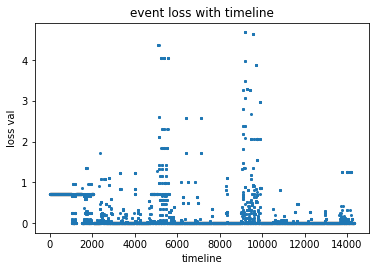

2018-04-06 00:15:50.177068871~2018-04-06 00:30:58.967045191.txt


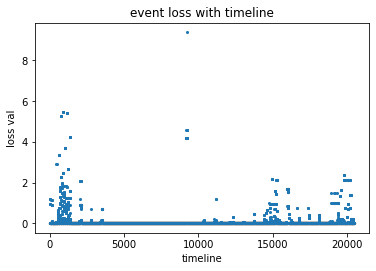

2018-04-06 00:30:58.967045191~2018-04-06 00:47:07.167023337.txt


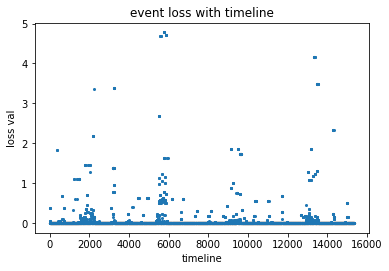

2018-04-06 00:47:07.167023337~2018-04-06 01:02:14.677010991.txt


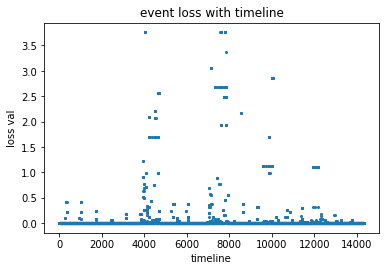

2018-04-06 01:02:14.677010991~2018-04-06 01:17:19.056982719.txt


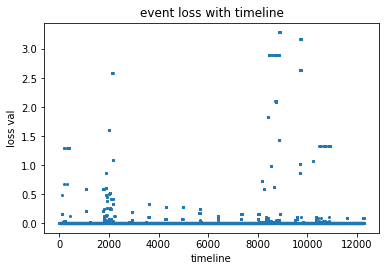

2018-04-06 01:17:19.056982719~2018-04-06 01:32:29.456961759.txt


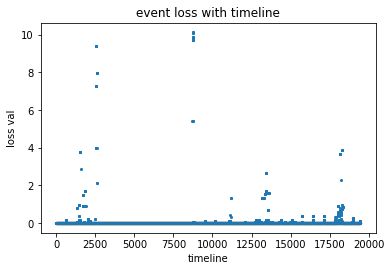

2018-04-06 01:32:29.456961759~2018-04-06 01:47:34.436947077.txt


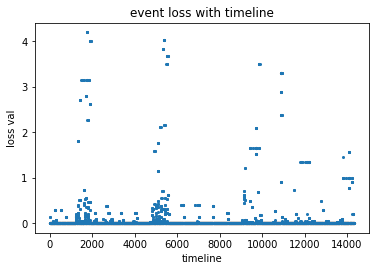

2018-04-06 01:47:34.436947077~2018-04-06 02:02:43.106920556.txt


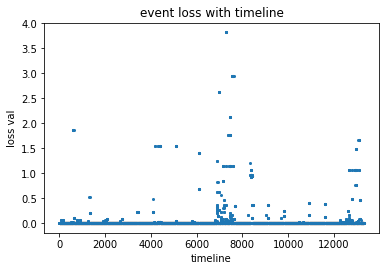

2018-04-06 02:02:43.106920556~2018-04-06 02:17:48.476901849.txt


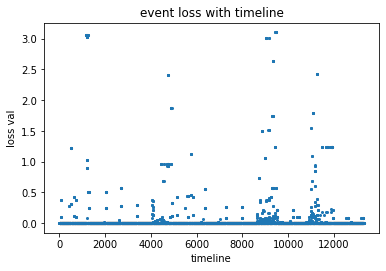

2018-04-06 02:17:48.476901849~2018-04-06 02:33:48.406880632.txt


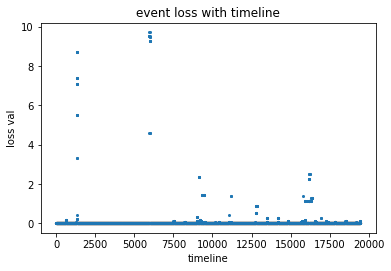

2018-04-06 02:33:48.406880632~2018-04-06 02:49:07.976859935.txt


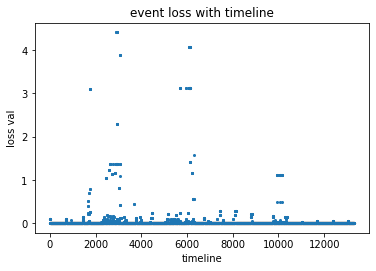

2018-04-06 02:49:07.976859935~2018-04-06 03:05:04.836837911.txt


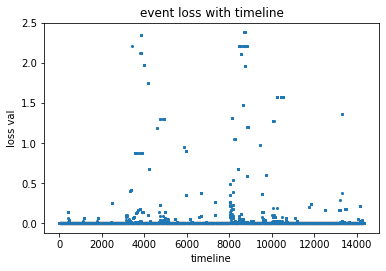

2018-04-06 03:05:04.836837911~2018-04-06 03:21:23.736815129.txt


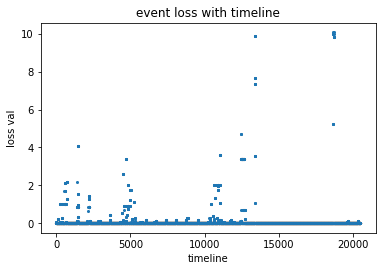

2018-04-06 03:21:23.736815129~2018-04-06 03:37:30.946794613.txt


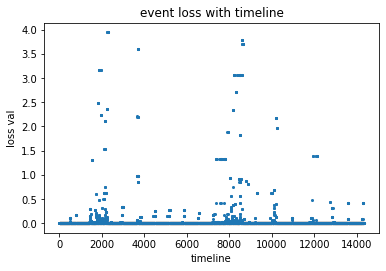

2018-04-06 03:37:30.946794613~2018-04-06 03:52:38.836775414.txt


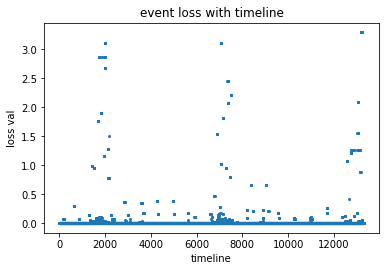

2018-04-06 03:52:38.836775414~2018-04-06 04:07:44.916766067.txt


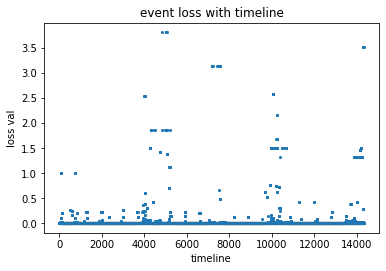

2018-04-06 04:07:44.916766067~2018-04-06 04:22:56.346731444.txt


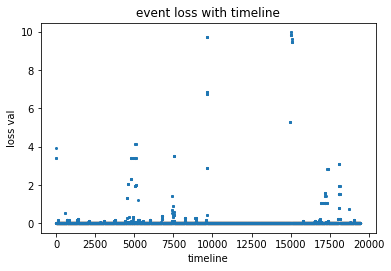

2018-04-06 04:22:56.346731444~2018-04-06 04:38:03.996711152.txt


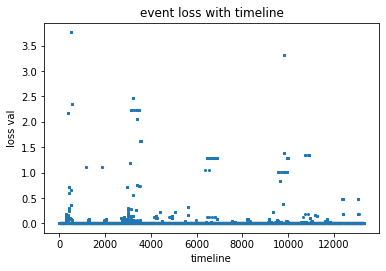

2018-04-06 04:38:03.996711152~2018-04-06 04:54:10.956696707.txt


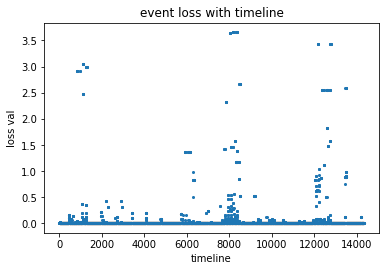

2018-04-06 04:54:10.956696707~2018-04-06 05:09:19.686673819.txt


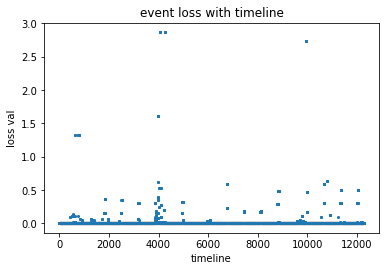

2018-04-06 05:09:19.686673819~2018-04-06 05:24:21.256650907.txt


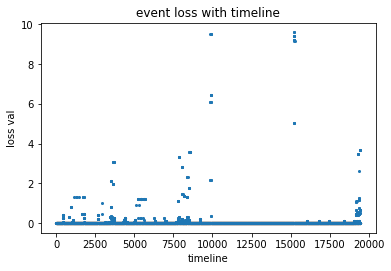

2018-04-06 05:24:21.256650907~2018-04-06 05:40:34.436635353.txt


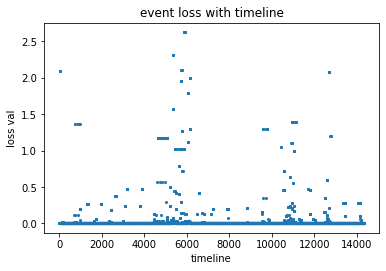

2018-04-06 05:40:34.436635353~2018-04-06 05:56:42.656608208.txt


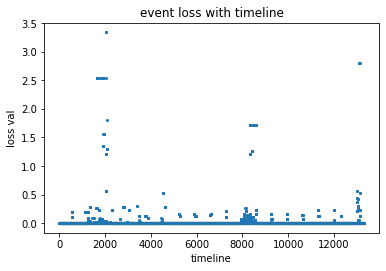

2018-04-06 05:56:42.656608208~2018-04-06 06:11:49.026587588.txt


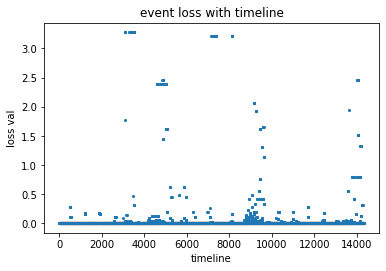

2018-04-06 06:11:49.026587588~2018-04-06 06:26:59.116568845.txt


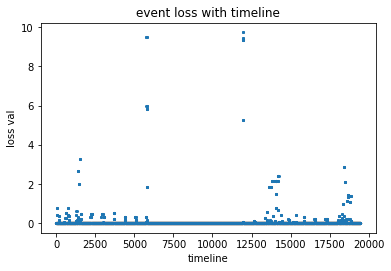

2018-04-06 06:26:59.116568845~2018-04-06 06:42:05.616549747.txt


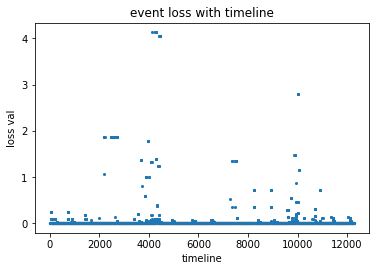

2018-04-06 06:42:05.616549747~2018-04-06 06:57:14.796527090.txt


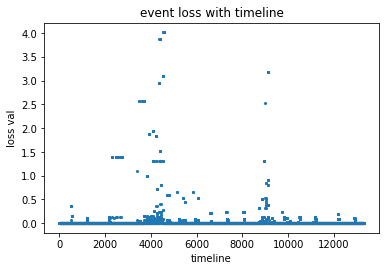

2018-04-06 06:57:14.796527090~2018-04-06 07:12:21.486507686.txt


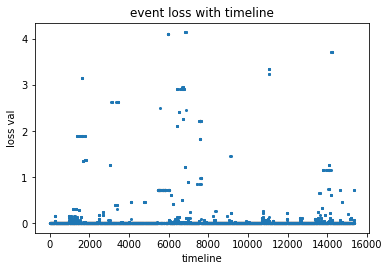

2018-04-06 07:12:21.486507686~2018-04-06 07:28:29.926483734.txt


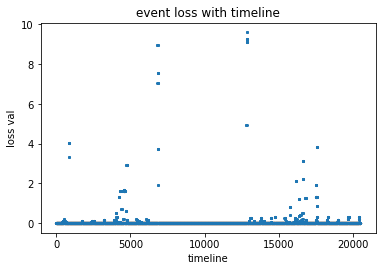

2018-04-06 07:28:29.926483734~2018-04-06 07:43:36.186466909.txt


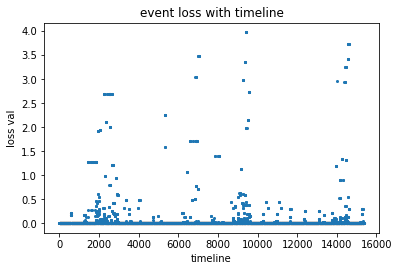

2018-04-06 07:43:36.186466909~2018-04-06 07:58:45.906442356.txt


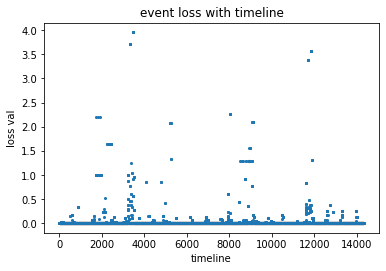

2018-04-06 07:58:45.906442356~2018-04-06 08:14:50.596423582.txt


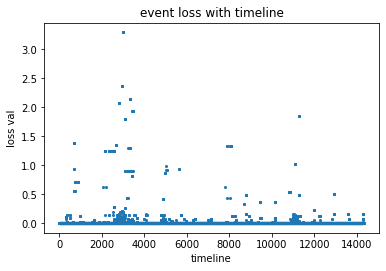

2018-04-06 08:14:50.596423582~2018-04-06 08:30:01.506400452.txt


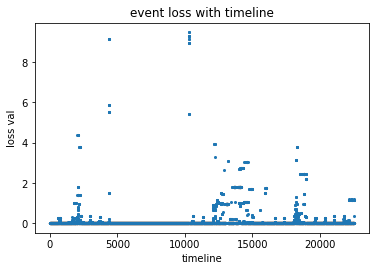

2018-04-06 08:30:01.506400452~2018-04-06 08:45:17.736385465.txt


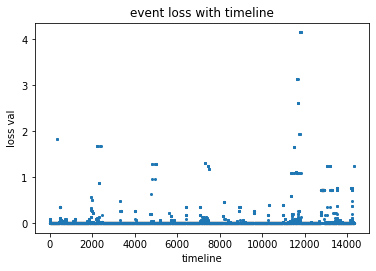

2018-04-06 08:45:17.736385465~2018-04-06 09:01:17.176359680.txt


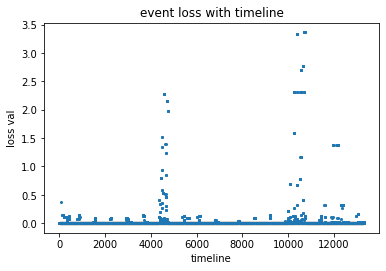

2018-04-06 09:01:17.176359680~2018-04-06 09:16:25.066340315.txt


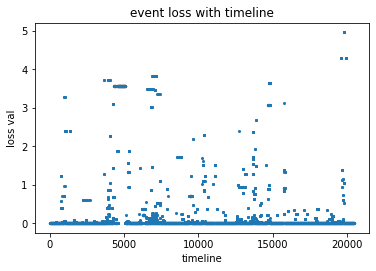

2018-04-06 09:16:25.066340315~2018-04-06 09:31:25.146320510.txt


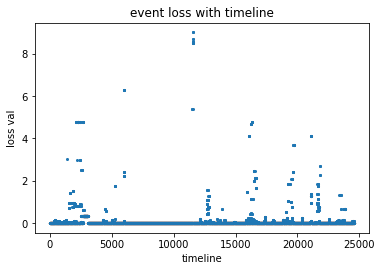

2018-04-06 09:31:25.146320510~2018-04-06 09:46:40.966296805.txt


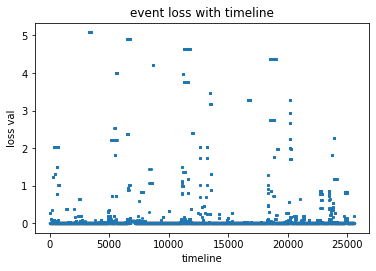

2018-04-06 09:46:40.966296805~2018-04-06 10:01:47.476279293.txt


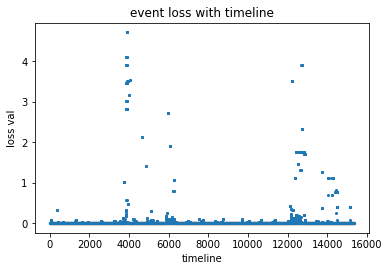

2018-04-06 10:01:47.476279293~2018-04-06 10:17:55.186257332.txt


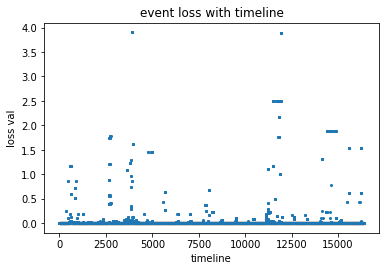

2018-04-06 10:17:55.186257332~2018-04-06 10:33:00.136241644.txt


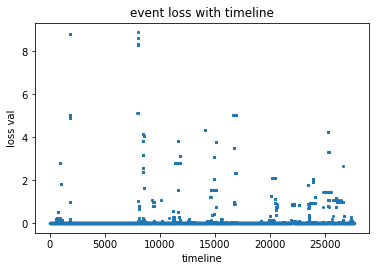

2018-04-06 10:33:00.136241644~2018-04-06 10:48:11.796216358.txt


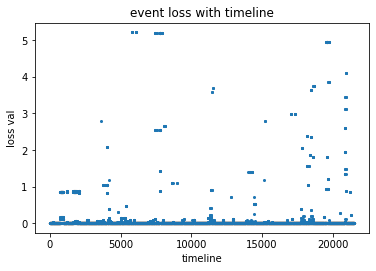

2018-04-06 10:48:11.796216358~2018-04-06 11:03:19.756210028.txt


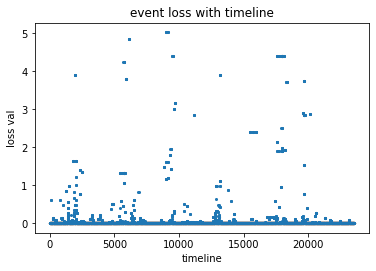

2018-04-06 11:03:19.756210028~2018-04-06 11:18:26.126177915.txt


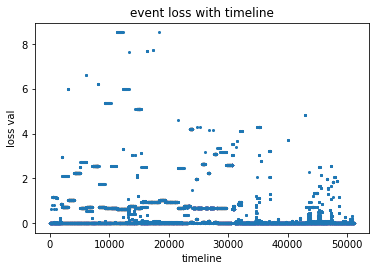

2018-04-06 11:18:26.126177915~2018-04-06 11:33:35.116170745.txt


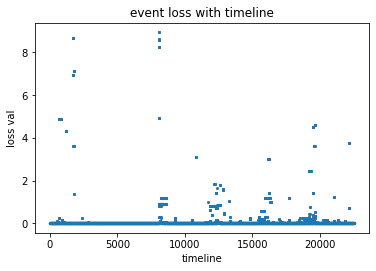

2018-04-06 11:33:35.116170745~2018-04-06 11:48:42.606135188.txt


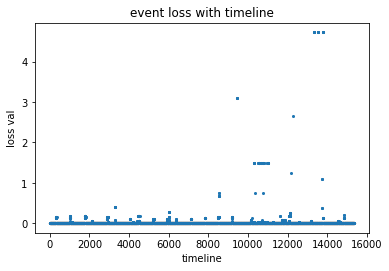

2018-04-06 11:48:42.606135188~2018-04-06 12:03:50.186115455.txt


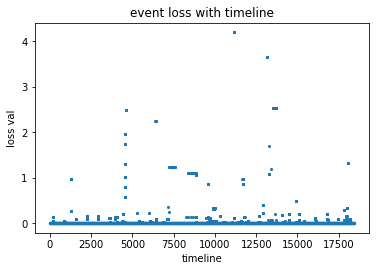

2018-04-06 12:03:50.186115455~2018-04-06 14:01:32.489584227.txt


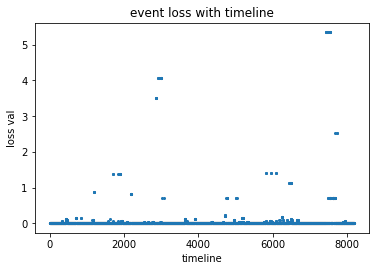

2018-04-06 14:01:32.489584227~2018-04-06 14:16:39.379560570.txt


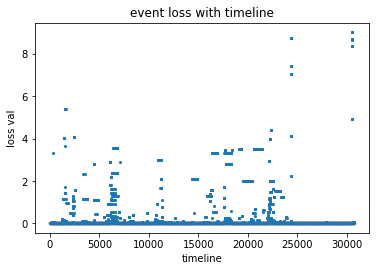

2018-04-06 14:16:39.379560570~2018-04-06 14:31:41.149538564.txt


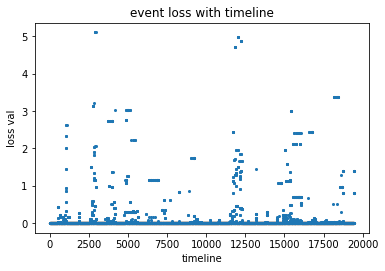

2018-04-06 14:31:41.149538564~2018-04-06 14:46:47.869522833.txt


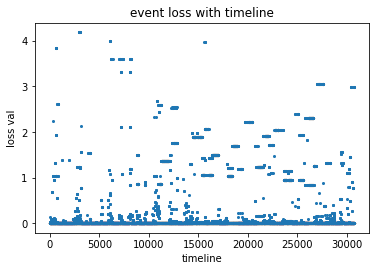

2018-04-06 14:46:47.869522833~2018-04-06 15:02:04.169502159.txt


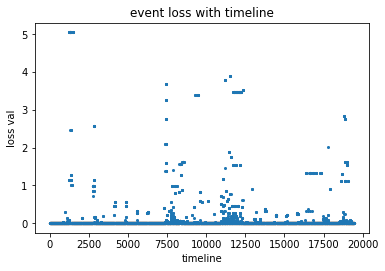

2018-04-06 15:02:04.169502159~2018-04-06 15:17:11.749480935.txt


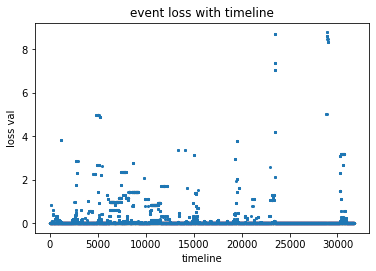

2018-04-06 15:17:11.749480935~2018-04-06 15:32:19.019459138.txt


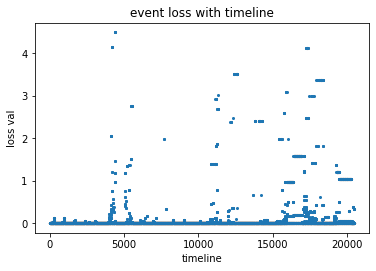

2018-04-06 15:32:19.019459138~2018-04-06 15:47:25.559439120.txt


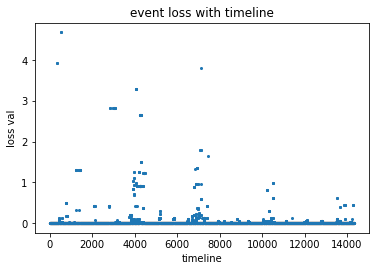

2018-04-06 15:47:25.559439120~2018-04-06 16:02:51.629418719.txt


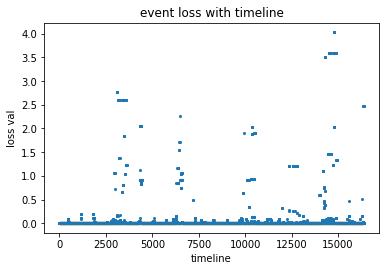

2018-04-06 16:02:51.629418719~2018-04-06 16:18:33.979401357.txt


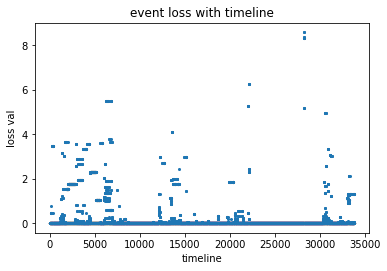

2018-04-06 16:18:33.979401357~2018-04-06 16:34:47.879379108.txt


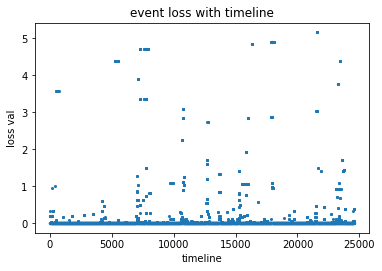

2018-04-06 16:34:47.879379108~2018-04-06 16:50:08.479356930.txt


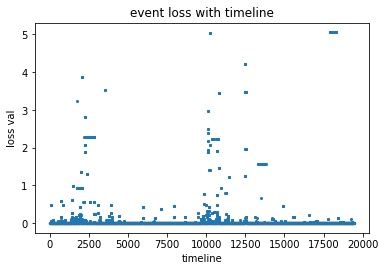

2018-04-06 16:50:08.479356930~2018-04-06 17:05:29.239333653.txt


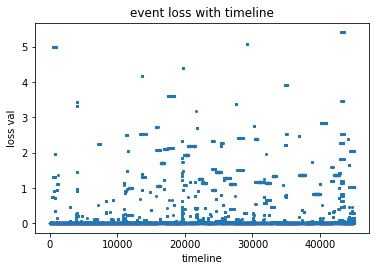

2018-04-06 17:05:29.239333653~2018-04-06 17:20:51.639321683.txt


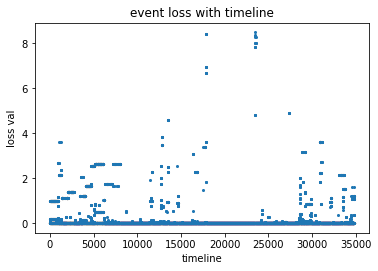

2018-04-06 17:20:51.639321683~2018-04-06 17:35:54.449302990.txt


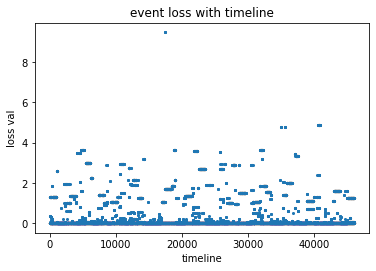

2018-04-06 17:35:54.449302990~2018-04-06 17:51:58.069270063.txt


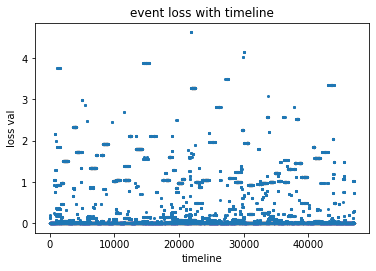

2018-04-06 17:51:58.069270063~2018-04-06 18:08:36.779250443.txt


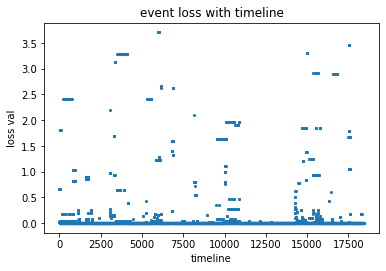

2018-04-06 18:08:36.779250443~2018-04-06 18:24:17.369229503.txt


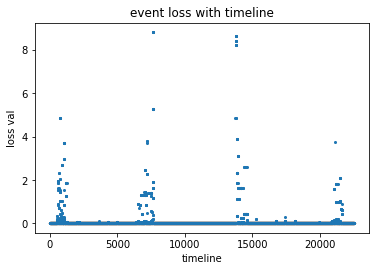

2018-04-06 18:24:17.369229503~2018-04-06 18:40:52.729207049.txt


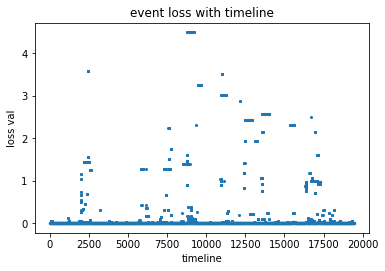

2018-04-06 18:40:52.729207049~2018-04-06 18:55:59.999193978.txt


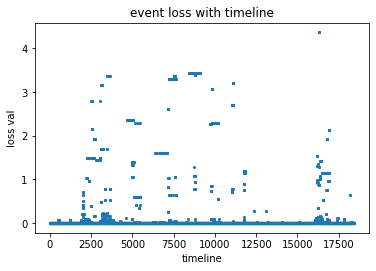

2018-04-06 18:55:59.999193978~2018-04-06 19:11:08.459167047.txt


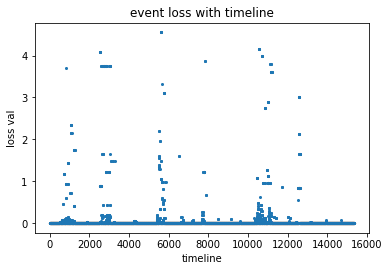

2018-04-06 19:11:08.459167047~2018-04-06 19:26:14.719145309.txt


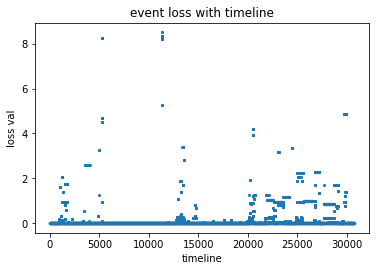

2018-04-06 19:26:14.719145309~2018-04-06 19:41:23.549124701.txt


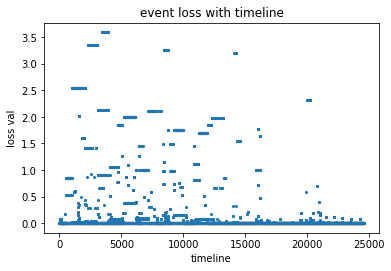

2018-04-06 19:41:23.549124701~2018-04-06 19:57:28.259104051.txt


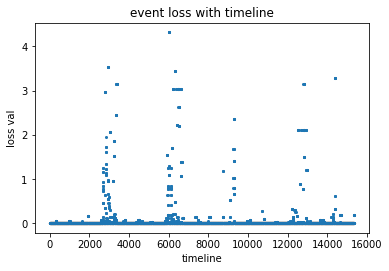

2018-04-06 19:57:28.259104051~2018-04-06 20:13:39.769084097.txt


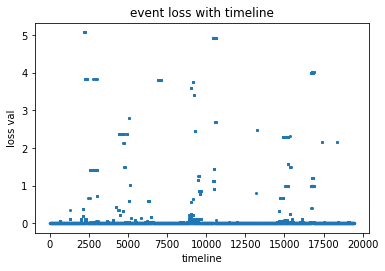

2018-04-06 20:13:39.769084097~2018-04-06 20:28:47.019060830.txt


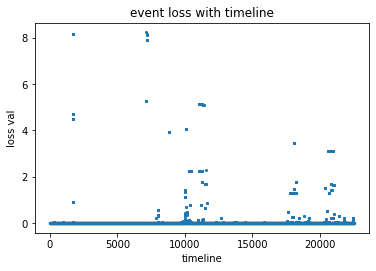

2018-04-06 20:28:47.019060830~2018-04-06 20:43:57.369040719.txt


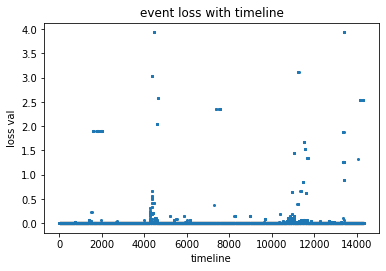

2018-04-06 20:43:57.369040719~2018-04-06 20:59:02.029030474.txt


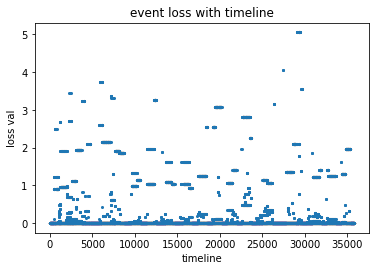

2018-04-06 20:59:02.029030474~2018-04-06 21:15:00.619010803.txt


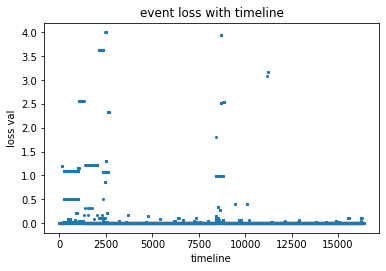

2018-04-06 21:15:00.619010803~2018-04-06 21:30:00.778978760.txt


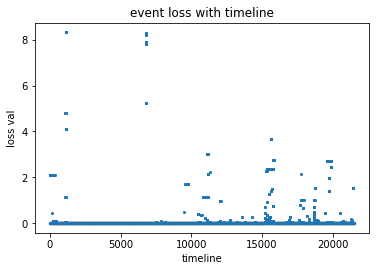

2018-04-06 21:30:00.778978760~2018-04-06 21:45:25.218957773.txt


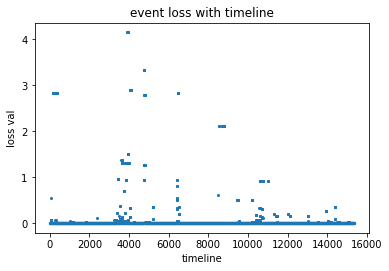

2018-04-06 21:45:25.218957773~2018-04-06 22:01:32.928937945.txt


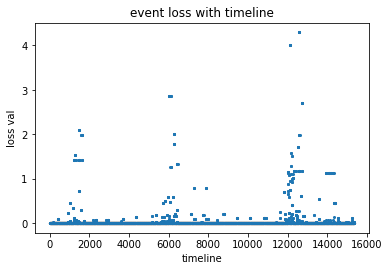

2018-04-06 22:01:32.928937945~2018-04-06 22:17:39.688914711.txt


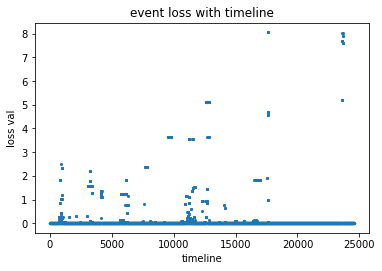

2018-04-06 22:17:39.688914711~2018-04-06 22:32:48.168897833.txt


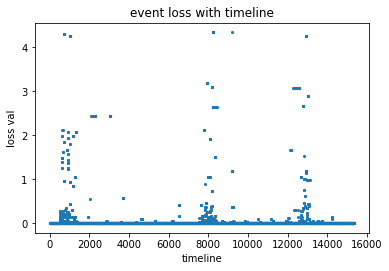

2018-04-06 22:32:48.168897833~2018-04-06 22:48:06.838874079.txt


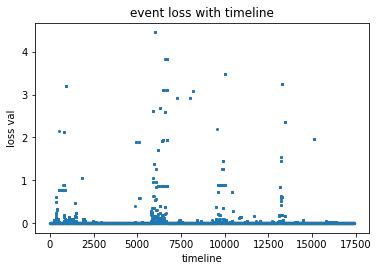

2018-04-06 22:48:06.838874079~2018-04-06 23:03:09.188854937.txt


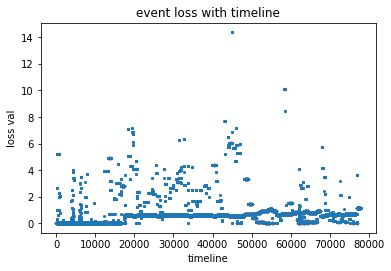

2018-04-06 23:03:09.188854937~2018-04-06 23:18:10.168840981.txt


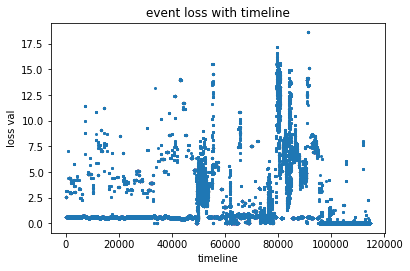

2018-04-06 23:18:10.168840981~2018-04-06 23:33:15.408814807.txt


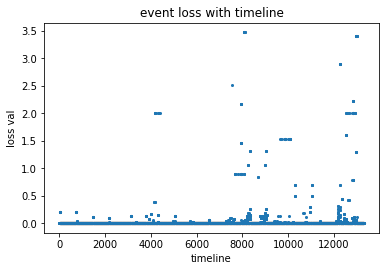

2018-04-06 23:33:15.408814807~2018-04-06 23:49:23.948792776.txt


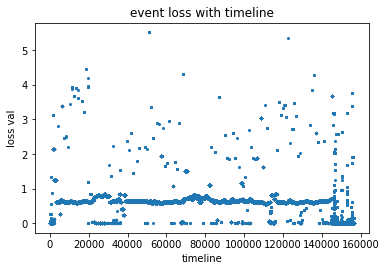

In [54]:
filelist = os.listdir("graph_4_6")
for i in filelist:
    f=open("graph_4_6/"+i)
    print(i)
    edge_list=[]
    for line in f:
        l=line.strip()
        jdata=eval(l)

        edge_list.append(jdata)
    edge_list = sorted(edge_list, key=lambda x:x['time'],reverse=False)#按照时间排序
    loss_list=[]
    for e in edge_list:
        loss_list.append(e['loss'])
    plotScatter_loss_with_time(loss_list)

In [53]:
import matplotlib.pyplot as plt
from pylab import *                                 #支持中文
def plotline_loss_with_time(loss_list):

    x = range(len(loss_list))

    #plt.plot(x, y, 'ro-')
    #plt.plot(x, y1, 'bo-')
    #pl.xlim(-1, 11)  # 限定横轴的范围
    #pl.ylim(-1, 110)  # 限定纵轴的范围
    plt.plot(x, loss_list, mec='r', mfc='w')
#     plt.legend()  # 让图例生效
    # plt.xticks(x, rotation=45) # x轴刻度旋转 以及x轴的内容
    # plt.margins(0)
    plt.subplots_adjust(bottom=0.15)
    plt.xlabel("timeline") #X轴标签
    plt.ylabel("loss val") #Y轴标签
    plt.title("event loss with timeline") #标题
    plt.scatter
    plt.show()
    
def plotScatter_loss_with_time(loss_list):

    x = range(len(loss_list))

    #plt.plot(x, y, 'ro-')
    #plt.plot(x, y1, 'bo-')
    #pl.xlim(-1, 11)  # 限定横轴的范围
    #pl.ylim(-1, 110)  # 限定纵轴的范围
    
    area = np.pi * 4**0.2 # 点面积
    plt.scatter(x, loss_list,s=area)
#     plt.legend()  # 让图例生效
    # plt.xticks(x, rotation=45) # x轴刻度旋转 以及x轴的内容
    # plt.margins(0)
    plt.subplots_adjust(bottom=0.15)
    plt.xlabel("timeline") #X轴标签
    plt.ylabel("loss val") #Y轴标签
    plt.title("event loss with timeline") #标题
    plt.scatter
    plt.show()

## 生成label

In [ ]:
labels={}
filelist = os.listdir("graph_4_6")
for f in filelist:
    labels[f]=0
filelist = os.listdir("graph_4_7")
for f in filelist:
    labels[f]=0   
    

In [ ]:
attack_list=[
    '2018-04-06 11:18:26.126177915~2018-04-06 11:33:35.116170745.txt',
    '2018-04-06 11:33:35.116170745~2018-04-06 11:48:42.606135188.txt',
    '2018-04-06 11:48:42.606135188~2018-04-06 12:03:50.186115455.txt',
    '2018-04-06 12:03:50.186115455~2018-04-06 14:01:32.489584227.txt',
]
for i in attack_list:
    labels[i]=1

    

In [173]:
labels

{'2018-04-06 00:00:00.017083676~2018-04-06 00:15:50.177068871.txt': 0,
 '2018-04-06 00:15:50.177068871~2018-04-06 00:30:58.967045191.txt': 0,
 '2018-04-06 00:30:58.967045191~2018-04-06 00:47:07.167023337.txt': 0,
 '2018-04-06 00:47:07.167023337~2018-04-06 01:02:14.677010991.txt': 0,
 '2018-04-06 01:02:14.677010991~2018-04-06 01:17:19.056982719.txt': 0,
 '2018-04-06 01:17:19.056982719~2018-04-06 01:32:29.456961759.txt': 0,
 '2018-04-06 01:32:29.456961759~2018-04-06 01:47:34.436947077.txt': 0,
 '2018-04-06 01:47:34.436947077~2018-04-06 02:02:43.106920556.txt': 0,
 '2018-04-06 02:02:43.106920556~2018-04-06 02:17:48.476901849.txt': 0,
 '2018-04-06 02:17:48.476901849~2018-04-06 02:33:48.406880632.txt': 0,
 '2018-04-06 02:33:48.406880632~2018-04-06 02:49:07.976859935.txt': 0,
 '2018-04-06 02:49:07.976859935~2018-04-06 03:05:04.836837911.txt': 0,
 '2018-04-06 03:05:04.836837911~2018-04-06 03:21:23.736815129.txt': 0,
 '2018-04-06 03:21:23.736815129~2018-04-06 03:37:30.946794613.txt': 0,
 '2018

## 统计与攻击相关的edge数量

In [9]:
def keyword_hit(line):
    attack_nodes=[
            'vUgefal',        
        '/var/log/devc',
        'nginx',   
        '81.49.200.166',
      '78.205.235.65',
        '200.36.109.214',
        '139.123.0.113',
        '152.111.159.139',
        '61.167.39.128',
             
        ]
    flag=False
    for i in attack_nodes:
        if i in line:
            flag=True
            break
    return flag

files=[]
temp_file=[
   '2018-04-06 11:18:26.126177915~2018-04-06 11:33:35.116170745.txt',
    '2018-04-06 11:33:35.116170745~2018-04-06 11:48:42.606135188.txt',
    '2018-04-06 11:48:42.606135188~2018-04-06 12:03:50.186115455.txt',
    '2018-04-06 12:03:50.186115455~2018-04-06 14:01:32.489584227.txt',
]
for f in temp_file:
    files.append("./graph_4_6/"+f)
    

In [10]:
files

['./graph_4_6/2018-04-06 11:18:26.126177915~2018-04-06 11:33:35.116170745.txt',
 './graph_4_6/2018-04-06 11:33:35.116170745~2018-04-06 11:48:42.606135188.txt',
 './graph_4_6/2018-04-06 11:48:42.606135188~2018-04-06 12:03:50.186115455.txt',
 './graph_4_6/2018-04-06 12:03:50.186115455~2018-04-06 14:01:32.489584227.txt']

In [11]:
attack_edge_count=0
for fpath in (files):
    f=open(fpath)
    for line in f:
        if keyword_hit(line):
            attack_edge_count+=1
print(attack_edge_count)

1248


## 测试  4-6\~13

In [ ]:
# 模型训练完以后执行下面这些测试函数，获取model对测试数据的重构误差输出

In [433]:
model=torch.load("./models/model_saved_emb100_BATCH_1024_LastAggregator_multiclass.pt")
memory,gnn, link_pred,neighbor_loader=model
ans_4_3=test_day_new(graph_4_3,"graph_4_3")

after merge: TemporalData(dst=[1758192], msg=[1758192, 39], src=[1758192], t=[1758192])
Time: 2018-04-03 00:00:00.002884014~2018-04-03 00:15:29.682868556, Loss: 1.6174, Nodes_count: 15488, Cost Time: 12.69s
Time: 2018-04-03 00:15:29.682868556~2018-04-03 00:30:39.652840273, Loss: 1.0982, Nodes_count: 15501, Cost Time: 15.57s
Time: 2018-04-03 00:30:39.652840273~2018-04-03 00:45:48.612820751, Loss: 1.3117, Nodes_count: 15501, Cost Time: 16.98s
Time: 2018-04-03 00:45:48.612820751~2018-04-03 01:00:57.722800088, Loss: 1.3334, Nodes_count: 15501, Cost Time: 18.35s
Time: 2018-04-03 01:00:57.722800088~2018-04-03 01:17:06.072775830, Loss: 1.3314, Nodes_count: 15515, Cost Time: 19.71s
Time: 2018-04-03 01:17:06.072775830~2018-04-03 01:32:16.902757103, Loss: 1.1077, Nodes_count: 15516, Cost Time: 21.65s
Time: 2018-04-03 01:32:16.902757103~2018-04-03 01:47:26.372745724, Loss: 1.3013, Nodes_count: 15516, Cost Time: 23.10s
Time: 2018-04-03 01:47:26.372745724~2018-04-03 02:02:35.472713620, Loss: 1.3196

Time: 2018-04-03 17:36:35.351467883~2018-04-03 17:51:43.161442042, Loss: 1.2947, Nodes_count: 18366, Cost Time: 153.09s
Time: 2018-04-03 17:51:43.161442042~2018-04-03 18:07:48.711422162, Loss: 1.5215, Nodes_count: 18386, Cost Time: 155.76s
Time: 2018-04-03 18:07:48.711422162~2018-04-03 18:23:56.701398779, Loss: 1.3258, Nodes_count: 18411, Cost Time: 158.81s
Time: 2018-04-03 18:23:56.701398779~2018-04-03 18:40:05.281378008, Loss: 1.3356, Nodes_count: 18413, Cost Time: 160.51s
Time: 2018-04-03 18:40:05.281378008~2018-04-03 18:55:13.631357905, Loss: 1.3371, Nodes_count: 18413, Cost Time: 162.07s
Time: 2018-04-03 18:55:13.631357905~2018-04-03 19:11:19.271336540, Loss: 1.3360, Nodes_count: 18415, Cost Time: 163.60s
Time: 2018-04-03 19:11:19.271336540~2018-04-03 19:27:28.951316637, Loss: 1.1401, Nodes_count: 18418, Cost Time: 165.75s
Time: 2018-04-03 19:27:28.951316637~2018-04-03 19:43:37.151290672, Loss: 1.3303, Nodes_count: 18420, Cost Time: 167.34s
Time: 2018-04-03 19:43:37.151290672~2018

In [434]:
model=torch.load("./models/model_saved_emb100_BATCH_1024_LastAggregator_multiclass.pt")
memory,gnn, link_pred,neighbor_loader=model
ans_4_4=test_day_new(graph_4_4,"graph_4_4")

after merge: TemporalData(dst=[1677700], msg=[1677700, 39], src=[1677700], t=[1677700])
Time: 2018-04-04 00:00:00.010948818~2018-04-04 00:15:00.870926016, Loss: 1.4186, Nodes_count: 118, Cost Time: 1.24s
Time: 2018-04-04 00:15:00.870926016~2018-04-04 00:30:58.170905986, Loss: 1.1221, Nodes_count: 133, Cost Time: 3.07s
Time: 2018-04-04 00:30:58.170905986~2018-04-04 00:46:06.990886590, Loss: 1.3283, Nodes_count: 150, Cost Time: 4.55s
Time: 2018-04-04 00:46:06.990886590~2018-04-04 01:02:14.890863698, Loss: 1.3833, Nodes_count: 152, Cost Time: 5.99s
Time: 2018-04-04 01:02:14.890863698~2018-04-04 01:18:19.710844541, Loss: 1.2986, Nodes_count: 152, Cost Time: 7.29s
Time: 2018-04-04 01:18:19.710844541~2018-04-04 01:33:30.220824602, Loss: 1.1219, Nodes_count: 155, Cost Time: 9.29s
Time: 2018-04-04 01:33:30.220824602~2018-04-04 01:48:37.810800940, Loss: 1.3545, Nodes_count: 157, Cost Time: 10.65s
Time: 2018-04-04 01:48:37.810800940~2018-04-04 02:03:45.210785278, Loss: 1.3448, Nodes_count: 157, 

Time: 2018-04-04 18:01:39.579497690~2018-04-04 18:16:41.079478593, Loss: 1.3803, Nodes_count: 1176, Cost Time: 144.66s
Time: 2018-04-04 18:16:41.079478593~2018-04-04 18:31:55.609456605, Loss: 1.1630, Nodes_count: 1180, Cost Time: 146.83s
Time: 2018-04-04 18:31:55.609456605~2018-04-04 18:47:01.579438295, Loss: 1.3724, Nodes_count: 1181, Cost Time: 148.41s
Time: 2018-04-04 18:47:01.579438295~2018-04-04 19:02:11.359417321, Loss: 1.3889, Nodes_count: 1183, Cost Time: 150.02s
Time: 2018-04-04 19:02:11.359417321~2018-04-04 19:18:19.169395880, Loss: 1.4016, Nodes_count: 1187, Cost Time: 151.63s
Time: 2018-04-04 19:18:19.169395880~2018-04-04 19:34:27.549373985, Loss: 1.1619, Nodes_count: 1190, Cost Time: 153.80s
Time: 2018-04-04 19:34:27.549373985~2018-04-04 19:49:35.319353447, Loss: 1.3536, Nodes_count: 1191, Cost Time: 155.36s
Time: 2018-04-04 19:49:35.319353447~2018-04-04 20:05:43.199330783, Loss: 1.4337, Nodes_count: 1209, Cost Time: 156.98s
Time: 2018-04-04 20:05:43.199330783~2018-04-04 2

In [435]:
model=torch.load("./models/model_saved_emb100_BATCH_1024_LastAggregator_multiclass.pt")
memory,gnn, link_pred,neighbor_loader=model
ans_4_5=test_day_new(graph_4_5,"graph_4_5")

after merge: TemporalData(dst=[1936142], msg=[1936142, 39], src=[1936142], t=[1936142])
Time: 2018-04-05 00:00:00.019021794~2018-04-05 00:15:00.828996051, Loss: 1.4464, Nodes_count: 131, Cost Time: 1.41s
Time: 2018-04-05 00:15:00.828996051~2018-04-05 00:31:53.958984540, Loss: 1.1830, Nodes_count: 145, Cost Time: 3.58s
Time: 2018-04-05 00:31:53.958984540~2018-04-05 00:47:02.738955442, Loss: 1.3875, Nodes_count: 148, Cost Time: 5.29s
Time: 2018-04-05 00:47:02.738955442~2018-04-05 01:02:10.248933422, Loss: 1.3746, Nodes_count: 148, Cost Time: 6.85s
Time: 2018-04-05 01:02:10.248933422~2018-04-05 01:17:16.198913636, Loss: 1.4054, Nodes_count: 151, Cost Time: 8.41s
Time: 2018-04-05 01:17:16.198913636~2018-04-05 01:32:24.868893768, Loss: 1.1469, Nodes_count: 152, Cost Time: 10.48s
Time: 2018-04-05 01:32:24.868893768~2018-04-05 01:48:31.268873586, Loss: 1.4127, Nodes_count: 170, Cost Time: 12.15s
Time: 2018-04-05 01:48:31.268873586~2018-04-05 02:03:38.918851533, Loss: 1.3808, Nodes_count: 170,

Time: 2018-04-05 17:45:00.787588203~2018-04-05 18:00:00.897576901, Loss: 1.4022, Nodes_count: 1985, Cost Time: 168.66s
Time: 2018-04-05 18:00:00.897576901~2018-04-05 18:15:51.217550065, Loss: 1.3878, Nodes_count: 1992, Cost Time: 170.45s
Time: 2018-04-05 18:15:51.217550065~2018-04-05 18:31:58.647526739, Loss: 1.2055, Nodes_count: 2005, Cost Time: 172.95s
Time: 2018-04-05 18:31:58.647526739~2018-04-05 18:47:07.857504183, Loss: 1.3870, Nodes_count: 2017, Cost Time: 175.13s
Time: 2018-04-05 18:47:07.857504183~2018-04-05 19:02:51.597488187, Loss: 1.4161, Nodes_count: 2029, Cost Time: 177.08s
Time: 2018-04-05 19:02:51.597488187~2018-04-05 19:19:21.927461058, Loss: 1.3815, Nodes_count: 2038, Cost Time: 179.03s
Time: 2018-04-05 19:19:21.927461058~2018-04-05 19:34:28.807441594, Loss: 1.2732, Nodes_count: 2057, Cost Time: 181.95s
Time: 2018-04-05 19:34:28.807441594~2018-04-05 19:50:39.457421452, Loss: 1.4467, Nodes_count: 2068, Cost Time: 184.24s
Time: 2018-04-05 19:50:39.457421452~2018-04-05 2

In [28]:
model=torch.load("./models/model_saved_emb100_BATCH_1024_LastAggregator_multiclass_without_neg_edge.pt")
memory,gnn, link_pred,neighbor_loader=model
ans_4_7=test_day_new(graph_4_7,"graph_4_7")

after merge: TemporalData(dst=[2284034], msg=[2284034, 39], src=[2284034], t=[2284034])
Time: 2018-04-07 00:00:00.008778912~2018-04-07 00:15:00.638758012, Loss: 0.8322, Nodes_count: 251, Cost Time: 2.05s
Time: 2018-04-07 00:15:00.638758012~2018-04-07 00:30:00.678739107, Loss: 1.2312, Nodes_count: 16289, Cost Time: 11.33s
Time: 2018-04-07 00:30:00.678739107~2018-04-07 00:45:48.008718917, Loss: 0.7651, Nodes_count: 16302, Cost Time: 14.01s
Time: 2018-04-07 00:45:48.008718917~2018-04-07 01:01:00.048699594, Loss: 0.7588, Nodes_count: 16315, Cost Time: 16.09s
Time: 2018-04-07 01:01:00.048699594~2018-04-07 01:17:08.118674396, Loss: 0.5362, Nodes_count: 16346, Cost Time: 18.71s
Time: 2018-04-07 01:17:08.118674396~2018-04-07 01:32:15.738656469, Loss: 0.7198, Nodes_count: 16356, Cost Time: 20.66s
Time: 2018-04-07 01:32:15.738656469~2018-04-07 01:48:06.728632339, Loss: 0.7346, Nodes_count: 16367, Cost Time: 22.58s
Time: 2018-04-07 01:48:06.728632339~2018-04-07 02:04:30.508619128, Loss: 0.7414, N

Time: 2018-04-07 17:28:15.007384019~2018-04-07 17:43:22.657350334, Loss: 1.3399, Nodes_count: 23735, Cost Time: 220.88s
Time: 2018-04-07 17:43:22.657350334~2018-04-07 17:59:27.637330849, Loss: 1.0781, Nodes_count: 23998, Cost Time: 226.26s
Time: 2018-04-07 17:59:27.637330849~2018-04-07 18:14:38.467310967, Loss: 0.8031, Nodes_count: 24007, Cost Time: 229.00s
Time: 2018-04-07 18:14:38.467310967~2018-04-07 18:29:44.957289774, Loss: 0.7119, Nodes_count: 24027, Cost Time: 233.24s
Time: 2018-04-07 18:29:44.957289774~2018-04-07 18:45:53.477266719, Loss: 1.1128, Nodes_count: 24400, Cost Time: 239.21s
Time: 2018-04-07 18:45:53.477266719~2018-04-07 19:01:01.807254480, Loss: 0.8066, Nodes_count: 24415, Cost Time: 242.44s
Time: 2018-04-07 19:01:01.807254480~2018-04-07 19:16:09.237229592, Loss: 0.5651, Nodes_count: 24428, Cost Time: 245.70s
Time: 2018-04-07 19:16:09.237229592~2018-04-07 19:31:16.917209075, Loss: 0.8564, Nodes_count: 24447, Cost Time: 249.16s
Time: 2018-04-07 19:31:16.917209075~2018

In [29]:
model=torch.load("./models/model_saved_emb100_BATCH_1024_LastAggregator_multiclass_without_neg_edge.pt")
memory,gnn, link_pred,neighbor_loader=model
ans_4_6=test_day_new(graph_4_6,"graph_4_6")

after merge: TemporalData(dst=[2022481], msg=[2022481, 39], src=[2022481], t=[2022481])
Time: 2018-04-06 00:00:00.017083676~2018-04-06 00:15:50.177068871, Loss: 0.7937, Nodes_count: 166, Cost Time: 1.96s
Time: 2018-04-06 00:15:50.177068871~2018-04-06 00:30:58.967045191, Loss: 0.5450, Nodes_count: 201, Cost Time: 4.74s
Time: 2018-04-06 00:30:58.967045191~2018-04-06 00:47:07.167023337, Loss: 0.7471, Nodes_count: 217, Cost Time: 7.21s
Time: 2018-04-06 00:47:07.167023337~2018-04-06 01:02:14.677010991, Loss: 0.7336, Nodes_count: 231, Cost Time: 9.75s
Time: 2018-04-06 01:02:14.677010991~2018-04-06 01:17:19.056982719, Loss: 0.7229, Nodes_count: 240, Cost Time: 11.96s
Time: 2018-04-06 01:17:19.056982719~2018-04-06 01:32:29.456961759, Loss: 0.4985, Nodes_count: 248, Cost Time: 14.82s
Time: 2018-04-06 01:32:29.456961759~2018-04-06 01:47:34.436947077, Loss: 0.7598, Nodes_count: 264, Cost Time: 17.37s
Time: 2018-04-06 01:47:34.436947077~2018-04-06 02:02:43.106920556, Loss: 0.7303, Nodes_count: 276

Time: 2018-04-06 19:26:14.719145309~2018-04-06 19:41:23.549124701, Loss: 1.0746, Nodes_count: 6328, Cost Time: 228.77s
Time: 2018-04-06 19:41:23.549124701~2018-04-06 19:57:28.259104051, Loss: 0.7977, Nodes_count: 6337, Cost Time: 231.51s
Time: 2018-04-06 19:57:28.259104051~2018-04-06 20:13:39.769084097, Loss: 0.9372, Nodes_count: 6374, Cost Time: 234.58s
Time: 2018-04-06 20:13:39.769084097~2018-04-06 20:28:47.019060830, Loss: 0.6570, Nodes_count: 6388, Cost Time: 238.49s
Time: 2018-04-06 20:28:47.019060830~2018-04-06 20:43:57.369040719, Loss: 0.7818, Nodes_count: 6398, Cost Time: 241.24s
Time: 2018-04-06 20:43:57.369040719~2018-04-06 20:59:02.029030474, Loss: 1.2546, Nodes_count: 6999, Cost Time: 247.14s
Time: 2018-04-06 20:59:02.029030474~2018-04-06 21:15:00.619010803, Loss: 0.8828, Nodes_count: 7045, Cost Time: 250.58s
Time: 2018-04-06 21:15:00.619010803~2018-04-06 21:30:00.778978760, Loss: 0.5989, Nodes_count: 7061, Cost Time: 254.05s
Time: 2018-04-06 21:30:00.778978760~2018-04-06 2

## 计算异常分数函数定义

In [84]:
def cal_train_IDF(find_str,file_list):
    include_count=0
    for f_path in (file_list):
        f=open(f_path)
        if find_str in f.read():
            include_count+=1             
    IDF=math.log(len(file_list)/(include_count+1))
    return IDF


def cal_IDF(find_str,file_path,file_list):
    file_list=os.listdir(file_path)
    include_count=0
    different_neighbor=set()#至少有两个 因此要减去2
    for f_path in (file_list):
        f=open(file_path+f_path)
        if find_str in f.read():
            include_count+=1
#         add=True
#         for line in f:
            
#             if find_str in line:
# #                 print(line)
#                 if add:
#                     include_count+=1
#                     add=False
#                 l=line.strip()
#                 jdata=eval(l)
#                 different_neighbor.add(jdata['srcmsg'])
#                 different_neighbor.add(jdata['dstmsg'])
                
                
    IDF=math.log(len(file_list)/(include_count+1))
    
    return IDF,1

def cal_redundant(find_str,edge_list):
    
    different_neighbor=set()#至少有两个 因此要减去2
    for e in edge_list:
        if find_str in str(e):
            different_neighbor.add(e[0])
            different_neighbor.add(e[1])
    return len(different_neighbor)-2

def cal_anomaly_loss(loss_list,edge_list,file_path):
    
    if len(loss_list)!=len(edge_list):
        print("error!")
        return 0
    count=0
    loss_sum=0
    loss_std=std(loss_list)
    loss_mean=mean(loss_list)
    edge_set=set()
    node_set=set()
    node2redundant={}
    
    thr=loss_mean+1.5*loss_std

    print("thr:",thr)

    for i in range(len(loss_list)):
        if loss_list[i]>thr:
            count+=1
            src_node=edge_list[i][0]
            dst_node=edge_list[i][1]
            
            loss_sum+=loss_list[i]
    
            node_set.add(src_node)
            node_set.add(dst_node)
            edge_set.add(edge_list[i][0]+edge_list[i][1])
    return count, loss_sum/count,node_set,edge_set
#     return count, count/len(loss_list)

In [6]:
# 计算节点的IDF分数字典
node_IDF={}
node_set=set()

file_list=[]

file_path="graph_4_3/"
file_l=os.listdir("graph_4_3/")
for i in file_l:
    file_list.append(file_path+i)

file_path="graph_4_4/"
file_l=os.listdir("graph_4_4/")
for i in file_l:
    file_list.append(file_path+i)

file_path="graph_4_5/"
file_l=os.listdir("graph_4_5/")


for i in file_l:
    file_list.append(file_path+i)

for f_path in tqdm(file_list):
    f=open(f_path)
    for line in f:
        l=line.strip()
        jdata=eval(l)
        if jdata['loss']>0:
            if 'netflow' not in str(jdata['srcmsg']):
                node_set.add(str(jdata['srcmsg']))
            if 'netflow' not in str(jdata['dstmsg']):
                node_set.add(str(jdata['dstmsg'])) 

for n in tqdm(node_set):
    find_str=list(eval(n).values())[0]
    IDF=cal_train_IDF(n,file_list)
    node_IDF[n]=IDF
#     if 'subject' in n:
#         node_IDF[n]=IDF*1
#     else:
#         node_IDF[n]=IDF*diff_ner

torch.save(node_IDF,"node_IDF_4_3-4_5")
print("IDF weight calculate complete!")

  2%|▏         | 6/277 [00:04<03:31,  1.28it/s]


KeyboardInterrupt: 

## 窗口关系建立函数

In [168]:
file_list=[]

file_path="graph_4_3/"
file_l=os.listdir("graph_4_3/")
for i in file_l:
    file_list.append(file_path+i)

file_path="graph_4_4/"
file_l=os.listdir("graph_4_4/")
for i in file_l:
    file_list.append(file_path+i)

file_path="graph_4_5/"
file_l=os.listdir("graph_4_5/")
for i in file_l:
    file_list.append(file_path+i)
    

def is_include_key_word(s):
    # finetune的函数
    keywords=[
         'netflow',
        '/home/george/Drafts' ,
        'usr',
        'proc',
        'var',
        'cadet',
        '/var/log/debug.log',
        '/var/log/cron',
        '/home/charles/Drafts',
        '/etc/ssl/cert.pem',
        '/tmp/.31.3022e',
      ]
    flag=False
    for i in keywords:
        if i in s:
            flag=True
    return flag
    
def cal_set_rel(s1,s2):
    new_s=s1 & s2
    count=0

    for i in new_s:

        if is_include_key_word(i) is not True:

            if i in node_IDF.keys():
                IDF=node_IDF[i]
            else:
                IDF=math.log(len(file_list)/(1))
            if IDF>(math.log(len(file_list)*0.9)):
                print("node:",i," IDF:",IDF)
                count+=1
    return count

## 新检测机制 4-6

In [100]:

node_IDF=torch.load("node_IDF_4_3-4_5")
y_data_4_6=[]
df_list_4_6=[]
# node_set_list=[]
history_list=[]
tw_que=[]
his_tw={}
current_tw={}

file_l=os.listdir("graph_4_6")
index_count=0
for f_path in (file_l):
    f=open("graph_4_6/"+f_path)
    edge_loss_list=[]
    edge_list=[]
    print('index_count:',index_count)
    
    for line in f:
        l=line.strip()
        jdata=eval(l)
        edge_loss_list.append(jdata['loss'])
        edge_list.append([str(jdata['srcmsg']),str(jdata['dstmsg'])])
    df_list_4_6.append(pd.DataFrame(edge_loss_list))
    count,loss_avg,node_set,edge_set=cal_anomaly_loss(edge_loss_list,edge_list,"graph_4_6/")
    current_tw['name']=f_path
    current_tw['loss']=loss_avg
    current_tw['index']=index_count
    current_tw['nodeset']=node_set

    added_que_flag=False
    for hq in history_list:
        for his_tw in hq:
            if cal_set_rel(current_tw['nodeset'],his_tw['nodeset'])!=0 and current_tw['name']!=his_tw['name']:
                hq.append(copy.deepcopy(current_tw))
                added_que_flag=True
                break
            if added_que_flag:
                break
    if added_que_flag is False:
        temp_hq=[copy.deepcopy(current_tw)]
        history_list.append(temp_hq)
    index_count+=1
    print( f_path,"  ",loss_avg," count:",count," percentage:",count/len(edge_list)," node count:",len(node_set)," edge count:",len(edge_set))


index_count: 0
thr: 1.9059028238183373
2018-04-06 00:00:00.017083676~2018-04-06 00:15:50.177068871.txt    2.4325370774582518  count: 852  percentage: 0.05943080357142857  node count: 90  edge count: 124
index_count: 1
thr: 1.632616303969652
2018-04-06 00:15:50.177068871~2018-04-06 00:30:58.967045191.txt    2.055919032488673  count: 2361  percentage: 0.115283203125  node count: 109  edge count: 196
index_count: 2
thr: 1.9013858893516735
2018-04-06 00:30:58.967045191~2018-04-06 00:47:07.167023337.txt    2.503054702306684  count: 964  percentage: 0.06276041666666667  node count: 76  edge count: 108
index_count: 3
thr: 1.8755028936709648
2018-04-06 00:47:07.167023337~2018-04-06 01:02:14.677010991.txt    2.3733837886647504  count: 1031  percentage: 0.07191685267857142  node count: 85  edge count: 130
index_count: 4
thr: 1.8340562819342778
2018-04-06 01:02:14.677010991~2018-04-06 01:17:19.056982719.txt    2.2185194691208445  count: 1067  percentage: 0.08683268229166667  node count: 78  edge 

thr: 2.536104247313488
2018-04-06 10:33:00.136241644~2018-04-06 10:48:11.796216358.txt    3.9874170278505217  count: 1171  percentage: 0.054454985119047616  node count: 118  edge count: 165
index_count: 42
thr: 2.457130576028616
2018-04-06 10:48:11.796216358~2018-04-06 11:03:19.756210028.txt    3.449604467247544  count: 1598  percentage: 0.06784986413043478  node count: 75  edge count: 81
index_count: 43
thr: 3.142310063962654
2018-04-06 11:03:19.756210028~2018-04-06 11:18:26.126177915.txt    4.23221475589579  count: 4515  percentage: 0.08818359375  node count: 351  edge count: 352
index_count: 44
thr: 1.823731522694001
node: {'subject': 'links'}  IDF: 5.6240175061873385
node: {'file': '/home/user/.links/links.his'}  IDF: 5.6240175061873385
2018-04-06 11:18:26.126177915~2018-04-06 11:33:35.116170745.txt    2.424335654356971  count: 1990  percentage: 0.08833451704545454  node count: 138  edge count: 224
index_count: 45
thr: 1.9465580052802247
node: {'subject': 'vUgefal'}  IDF: 5.6240175

thr: 2.088033500572279
2018-04-06 22:17:39.688914711~2018-04-06 22:32:48.168897833.txt    3.2722715185103515  count: 678  percentage: 0.044140625  node count: 69  edge count: 86
index_count: 81
thr: 2.318438402223474
2018-04-06 22:32:48.168897833~2018-04-06 22:48:06.838874079.txt    3.7213580006559477  count: 931  percentage: 0.053481158088235295  node count: 69  edge count: 81
index_count: 82
thr: 2.131332510658014
2018-04-06 22:48:06.838874079~2018-04-06 23:03:09.188854937.txt    3.331225376887755  count: 2200  percentage: 0.02826891447368421  node count: 197  edge count: 206
index_count: 83
thr: 3.179538521783452
node: {'file': '/tmp/periodic.L7oz7KTJ1r'}  IDF: 5.6240175061873385
2018-04-06 23:03:09.188854937~2018-04-06 23:18:10.168840981.txt    4.406651209006607  count: 10243  percentage: 0.08931187220982142  node count: 1771  edge count: 1755
index_count: 84
thr: 1.865272283680663
2018-04-06 23:18:10.168840981~2018-04-06 23:33:15.408814807.txt    2.337114972441564  count: 1012  pe

In [101]:

pred_label={}

filelist = os.listdir("graph_4_6")
for f in filelist:
    pred_label[f]=0
    
filelist = os.listdir("graph_4_7")
for f in filelist:
    pred_label[f]=0

for hl in history_list:
    loss_count=0
    for hq in hl:
        if loss_count==0:
            loss_count=(loss_count+1)*(hq['loss']+1)
        else:
            loss_count=(loss_count)*(hq['loss']+1)
    name_list=[]
    if loss_count>100:
        name_list=[]
        for i in hl:
            name_list.append(i['name'])
        print(name_list)
        for i in name_list:
            pred_label[i]=1
        print(loss_count)

['2018-04-06 11:03:19.756210028~2018-04-06 11:18:26.126177915.txt', '2018-04-06 11:18:26.126177915~2018-04-06 11:33:35.116170745.txt', '2018-04-06 11:33:35.116170745~2018-04-06 11:48:42.606135188.txt', '2018-04-06 11:48:42.606135188~2018-04-06 12:03:50.186115455.txt', '2018-04-06 12:03:50.186115455~2018-04-06 14:01:32.489584227.txt']
814.4876959091091


## 新检测机制 4-7

In [104]:

node_IDF=torch.load("node_IDF_4_3-4_5")
y_data_4_7=[]
df_list_4_7=[]
# node_set_list=[]
history_list=[]
tw_que=[]
his_tw={}
current_tw={}

file_l=os.listdir("graph_4_7")
index_count=0
for f_path in (file_l):
    f=open("graph_4_7/"+f_path)
    edge_loss_list=[]
    edge_list=[]
    print('index_count:',index_count)
    
    for line in f:
        l=line.strip()
        jdata=eval(l)
        edge_loss_list.append(jdata['loss'])
        edge_list.append([str(jdata['srcmsg']),str(jdata['dstmsg'])])
    df_list_4_7.append(pd.DataFrame(edge_loss_list))
    count,loss_avg,node_set,edge_set=cal_anomaly_loss(edge_loss_list,edge_list,"graph_4_7/")
    current_tw['name']=f_path
    current_tw['loss']=loss_avg
    current_tw['index']=index_count
    current_tw['nodeset']=node_set

    added_que_flag=False
    for hq in history_list:
        for his_tw in hq:
            if cal_set_rel(current_tw['nodeset'],his_tw['nodeset'])!=0 and current_tw['name']!=his_tw['name']:
                hq.append(copy.deepcopy(current_tw))
                added_que_flag=True
                break
            if added_que_flag:
                break
    if added_que_flag is False:
        temp_hq=[copy.deepcopy(current_tw)]
        history_list.append(temp_hq)
  
    index_count+=1

    print( f_path,"  ",loss_avg," count:",count," percentage:",count/len(edge_list)," node count:",len(node_set)," edge count:",len(edge_set))


index_count: 0
thr: 1.9789371127142361
2018-04-07 00:00:00.008778912~2018-04-07 00:15:00.638758012.txt    2.6541447620093823  count: 800  percentage: 0.052083333333333336  node count: 124  edge count: 128
index_count: 1
thr: 2.2242069526023904
node: {'file': '/tmp/periodic.TWkmZ7gwrS'}  IDF: 5.6240175061873385
2018-04-07 00:15:00.638758012~2018-04-07 00:30:00.678739107.txt    3.7067076545424444  count: 2072  percentage: 0.026278409090909092  node count: 175  edge count: 181
index_count: 2
thr: 1.9347567584373841
2018-04-07 00:30:00.678739107~2018-04-07 00:45:48.008718917.txt    2.5860293648591854  count: 820  percentage: 0.05719866071428571  node count: 69  edge count: 95
index_count: 3
thr: 1.9098845436915197
2018-04-07 00:45:48.008718917~2018-04-07 01:01:00.048699594.txt    2.442401022458411  count: 927  percentage: 0.06466238839285714  node count: 78  edge count: 111
index_count: 4
thr: 1.598654614626975
2018-04-07 01:01:00.048699594~2018-04-07 01:17:08.118674396.txt    1.9947616950

thr: 2.223654451088379
2018-04-07 10:36:44.657924040~2018-04-07 10:51:55.367905007.txt    3.6554016693599714  count: 811  percentage: 0.046587775735294115  node count: 64  edge count: 76
index_count: 42
thr: 2.6740830374652225
2018-04-07 10:51:55.367905007~2018-04-07 11:07:01.987882382.txt    3.8045528104590547  count: 2081  percentage: 0.0812890625  node count: 90  edge count: 98
index_count: 43
thr: 2.5153840837220045
node: {'file': '/home/user/#pico21309#'}  IDF: 5.6240175061873385
2018-04-07 11:07:01.987882382~2018-04-07 11:22:08.247863262.txt    3.418746803949657  count: 3265  percentage: 0.06783992686170212  node count: 278  edge count: 309
index_count: 44
thr: 2.4553833600331525
2018-04-07 11:22:08.247863262~2018-04-07 11:37:19.117845222.txt    4.001692226188447  count: 1111  percentage: 0.06027560763888889  node count: 69  edge count: 74
index_count: 45
thr: 2.563526625352168
2018-04-07 11:37:19.117845222~2018-04-07 11:52:25.757824807.txt    3.749485399037044  count: 1769  perc

thr: 1.934509071923088
2018-04-07 21:03:02.457083343~2018-04-07 21:18:08.817071709.txt    3.113568397975104  count: 1227  percentage: 0.05705915178571429  node count: 85  edge count: 110
index_count: 83
thr: 2.1896365168868552
2018-04-07 21:18:08.817071709~2018-04-07 21:33:17.447051923.txt    3.7292626883113753  count: 677  percentage: 0.04407552083333333  node count: 61  edge count: 71
index_count: 84
thr: 2.2581751325680246
2018-04-07 21:33:17.447051923~2018-04-07 21:48:25.107022873.txt    4.03665699059846  count: 610  percentage: 0.04255022321428571  node count: 62  edge count: 71
index_count: 85
thr: 1.8991193785813985
2018-04-07 21:48:25.107022873~2018-04-07 22:03:32.547001547.txt    2.461663744884803  count: 893  percentage: 0.062290736607142856  node count: 84  edge count: 113
index_count: 86
thr: 1.858962693391349
2018-04-07 22:03:32.547001547~2018-04-07 22:18:38.656982046.txt    2.627083272018914  count: 1506  percentage: 0.07003348214285714  node count: 112  edge count: 171
i

In [105]:

for hl in history_list:
    loss_count=0
    for hq in hl:
        if loss_count==0:
            loss_count=(loss_count+1)*(hq['loss']+1)
        else:
            loss_count=(loss_count)*(hq['loss']+1)
    name_list=[]
    if loss_count>100:
        name_list=[]
        for i in hl:
            name_list.append(i['name'])
        print(name_list)
        # 下面先打上注释意味着先看下测试结果，先不往预测结果中加
#         for i in name_list:
#             pred_label[i]=1
        print(loss_count)

## 新检测机制 4-5

In [524]:
# 通过4-5的数据来确认阈值

node_IDF=torch.load("node_IDF_4_3-4_5")
y_data_4_5=[]
df_list_4_5=[]
# node_set_list=[]
history_list=[]
tw_que=[]
his_tw={}
current_tw={}

file_l=os.listdir("graph_4_5")
index_count=0
for f_path in (file_l):
    f=open("graph_4_5/"+f_path)
    edge_loss_list=[]
    edge_list=[]
    print('index_count:',index_count)
    
    for line in f:
        l=line.strip()
        jdata=eval(l)
        edge_loss_list.append(jdata['loss'])
        edge_list.append([str(jdata['srcmsg']),str(jdata['dstmsg'])])
    df_list_4_5.append(pd.DataFrame(edge_loss_list))
    count,loss_avg,node_set,edge_set=cal_anomaly_loss(edge_loss_list,edge_list,"graph_4_5/")
    current_tw['name']=f_path
    current_tw['loss']=loss_avg
    current_tw['index']=index_count
    current_tw['nodeset']=node_set

    added_que_flag=False
    for hq in history_list:
        for his_tw in hq:
            if cal_set_rel(current_tw['nodeset'],his_tw['nodeset'])!=0 and current_tw['name']!=his_tw['name']:
                hq.append(copy.deepcopy(current_tw))
                added_que_flag=True
                break
            if added_que_flag:
                break
    if added_que_flag is False:
        temp_hq=[copy.deepcopy(current_tw)]
        history_list.append(temp_hq)
  
    index_count+=1
#     node_set_list.append(node_set)
    print( f_path,"  ",loss_avg," count:",count," percentage:",count/len(edge_list)," node count:",len(node_set)," edge count:",len(edge_set))
#     y_data_4_10.append([loss_avg,labels_4_10[f_path],f_path])

index_count: 0
thr: 2.759841293568325
2018-04-03 00:00:00.002884014~2018-04-03 00:15:29.682868556.txt    3.021055505807212  count: 11762  percentage: 0.09817374465811966  node count: 5976  edge count: 5966
index_count: 1
thr: 2.671073867446984
2018-04-03 00:15:29.682868556~2018-04-03 00:30:39.652840273.txt    3.7904938938033523  count: 1457  percentage: 0.08892822265625  node count: 67  edge count: 61
index_count: 2
thr: 3.206307918232065
2018-04-03 00:30:39.652840273~2018-04-03 00:45:48.612820751.txt    4.016956664963984  count: 1067  percentage: 0.10419921875  node count: 51  edge count: 42
index_count: 3
thr: 3.262170543030109
2018-04-03 00:45:48.612820751~2018-04-03 01:00:57.722800088.txt    4.053397981240788  count: 1122  percentage: 0.1095703125  node count: 54  edge count: 45
index_count: 4
thr: 3.2409833222740234
2018-04-03 01:00:57.722800088~2018-04-03 01:17:06.072775830.txt    4.0724022427355715  count: 1042  percentage: 0.1017578125  node count: 53  edge count: 43
index_coun

thr: 3.4191249889875213
2018-04-03 10:53:09.112001488~2018-04-03 11:08:22.471986912.txt    4.23915490009967  count: 1765  percentage: 0.06383825231481481  node count: 166  edge count: 154
index_count: 43
thr: 2.8017481978841543
2018-04-03 11:08:22.471986912~2018-04-03 11:23:30.151962725.txt    3.7615606948413256  count: 1676  percentage: 0.09092881944444445  node count: 96  edge count: 96
index_count: 44
thr: 3.3563290685928657
2018-04-03 11:23:30.151962725~2018-04-03 11:38:36.571944378.txt    4.126814592186268  count: 1067  percentage: 0.07442801339285714  node count: 87  edge count: 75
index_count: 45
thr: 3.370428463786981
2018-04-03 11:38:36.571944378~2018-04-03 11:54:33.731921062.txt    4.197444492105589  count: 1399  percentage: 0.0759006076388889  node count: 120  edge count: 104
index_count: 46
thr: 3.315425959418704
2018-04-03 11:54:33.731921062~2018-04-03 12:10:52.921898290.txt    4.15763331494561  count: 1267  percentage: 0.07278262867647059  node count: 121  edge count: 106

thr: 3.21905972227657
2018-04-03 21:33:00.081145026~2018-04-03 21:49:35.501124075.txt    3.986145122973178  count: 1187  percentage: 0.10537997159090909  node count: 58  edge count: 49
index_count: 84
thr: 3.2201553115765984
2018-04-03 21:49:35.501124075~2018-04-03 22:04:46.871102664.txt    4.049410808228181  count: 1093  percentage: 0.09703480113636363  node count: 63  edge count: 54
index_count: 85
thr: 2.679234226606204
2018-04-03 22:04:46.871102664~2018-04-03 22:19:54.151081596.txt    3.68521399685043  count: 1504  percentage: 0.091796875  node count: 83  edge count: 87
index_count: 86
thr: 3.2233714583296473
2018-04-03 22:19:54.151081596~2018-04-03 22:35:00.301063638.txt    4.02232769599537  count: 1051  percentage: 0.10263671875  node count: 53  edge count: 43
index_count: 87
thr: 3.269223629763662
2018-04-03 22:35:00.301063638~2018-04-03 22:51:09.961039017.txt    4.04669147871673  count: 1219  percentage: 0.10822088068181818  node count: 57  edge count: 49
index_count: 88
thr: 4

In [525]:

# pred_label={}

files = os.listdir("graph_4_5")
for f in files:
    pred_label[f]=0


for hl in history_list:
    loss_count=0
    for hq in hl:
        if loss_count==0:
            loss_count=(loss_count+1)*(hq['loss']+1)
        else:
            loss_count=(loss_count)*(hq['loss']+1)
    name_list=[]
    if loss_count>100:
        name_list=[]
        for i in hl:
            name_list.append(i['name'])
        print(name_list)
        for i in name_list:
            pred_label[i]=1
        print(loss_count)

# 异常检测模块

In [20]:
from sklearn.metrics import average_precision_score, roc_auc_score
#导入plot_roc_curve,roc_curve和roc_auc_score模块
from sklearn.metrics import plot_roc_curve,roc_curve,auc,roc_auc_score
import torch
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

def plot_thr():
    np.seterr(invalid='ignore')
    step=0.01
    thr_list=torch.arange(-5,5,step)
    
    

    precision_list=[]
    recall_list=[]
    fscore_list=[]
    accuracy_list=[]
    auc_val_list=[]
    for thr in thr_list:
        threshold=thr
        y_prediction=[]
        for i in y_test_scores:
            if i >threshold:
                y_prediction.append(1)
            else:
                y_prediction.append(0)
        precision,recall,fscore,accuracy,auc_val=classifier_evaluation(y_test, y_prediction)   
        precision_list.append(float(precision))
        recall_list.append(float(recall))
        fscore_list.append(float(fscore))
        accuracy_list.append(float(accuracy))
        auc_val_list.append(float(auc_val))

    max_fscore=max(fscore_list)
    max_fscore_index=fscore_list.index(max_fscore)
    print(max_fscore_index)
    print("max threshold:",thr_list[max_fscore_index])
    print('precision:',precision_list[max_fscore_index])
    print('recall:',recall_list[max_fscore_index])
    print('fscore:',fscore_list[max_fscore_index])
    print('accuracy:',accuracy_list[max_fscore_index])    
    print('auc:',auc_val_list[max_fscore_index])
    
        
     # list 转 tensor   
#     precision_list=torch.tensor(precision_list)   
#     recall_list=torch.tensor(recall_list)   
#     fscore_list=torch.tensor(fscore_list)   
#     accuracy_list=torch.tensor(accuracy_list)   
#     auc_val_list=torch.tensor(auc_val_list)   

    


    
    # plt.scatter(attack_x, attack_y, s=20, c='r', label='Attack graph',marker='*')
    # plt.scatter(bengin_x, bengin_y, s=20, c='g', label='Bengin graph',marker='1')
    # plt.scatter(bengin_x, bengin_y, s=20, c='g', label='Bengin graph',marker='1')

    plt.plot(thr_list,precision_list,color='red',label='precision',linewidth=2.0,linestyle='-')
    plt.plot(thr_list,recall_list,color='orange',label='recall',linewidth=2.0,linestyle='solid')
    plt.plot(thr_list,fscore_list,color='y',label='F-score',linewidth=2.0,linestyle='dashed')
    plt.plot(thr_list,accuracy_list,color='g',label='accuracy',linewidth=2.0,linestyle='dashdot')
    plt.plot(thr_list,auc_val_list,color='b',label='auc_val',linewidth=2.0,linestyle='dotted')
    # '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'


    # plt.scatter(turnovers, graph_loss, c=color)
    plt.xlabel("Threshold", fontdict={'size': 16})
    plt.ylabel("Rate", fontdict={'size': 16})
    plt.title("Different evaluation Indicators by varying threshold value", fontdict={'size': 12})
    plt.legend(loc='best', fontsize=12, markerscale=0.5)
    plt.show()

def classifier_evaluation(y_test, y_test_pred):
    # groundtruth, pred_value
    tn, fp, fn, tp =confusion_matrix(y_test, y_test_pred).ravel()
#     tn+=100
#     print(clf_name," : ")
    print('tn:',tn)
    print('fp:',fp)
    print('fn:',fn)
    print('tp:',tp)
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    accuracy=(tp+tn)/(tp+tn+fp+fn)
    fscore=2*(precision*recall)/(precision+recall)    
    auc_val=roc_auc_score(y_test, y_test_pred)
    print("precision:",precision)
    print("recall:",recall)
    print("fscore:",fscore)
    print("accuracy:",accuracy)
    print("auc_val:",auc_val)
    return precision,recall,fscore,accuracy,auc_val

def minmax(data):
    min_val=min(data)
    max_val=max(data)
    ans=[]
    for i in data:
        ans.append((i-min_val)/(max_val-min_val))
    return ans


In [12]:

12,848

705,605

1,361

4

tp=12848
tn=705605
fp=1361
fn=4
precision=tp/(tp+fp)
recall=tp/(tp+fn)
accuracy=(tp+tn)/(tp+tn+fp+fn)
fscore=2*(precision*recall)/(precision+recall)    

print("precision:",round(precision,2))
print("recall:",round(recall,2))
print("fscore:",round(fscore,2))
print("accuracy:",round(accuracy,2))







precision: 0.9
recall: 1.0
fscore: 0.95
accuracy: 1.0


In [21]:
y=[]
y_pred=[]
for i in labels:
    y.append(labels[i])
    y_pred.append(pred_label[i])

In [22]:
classifier_evaluation(y,y_pred)

tn: 174
fp: 1
fn: 0
tp: 4
precision: 0.8
recall: 1.0
fscore: 0.888888888888889
accuracy: 0.994413407821229
auc_val: 0.9971428571428572


(0.8, 1.0, 0.888888888888889, 0.994413407821229, 0.9971428571428572)

In [26]:
import psutil


def getMemSize_MB(pid):
    # 根据进程号来获取进程的内存大小
    process = psutil.Process(pid)
    memInfo = process.memory_info()
    return memInfo.rss / 1024 / 1024

def getMemSize_GB(pid):
    # 根据进程号来获取进程的内存大小
    process = psutil.Process(pid)
    memInfo = process.memory_info()
    return memInfo.rss / 1024 / 1024 /1024



def getTotalM(processName):
    # 一个进程名对应的可能有多个进程
    # 进程号才是进程的唯一标识符，进程名不是
    totalM = 0
    totalG=0
    for i in psutil.process_iter():
        if i.name() == processName:
            totalM += getMemSize_MB(i.pid)
            totalG += getMemSize_GB(i.pid)
    print('%.2f MB' % totalM)
    print('%.2f GB' % totalG)
    return totalM


if __name__ == '__main__':
    getTotalM('top')



3.39 MB
0.00 GB
